In [449]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
from numpy import absolute, mean, std
from sklearn import preprocessing, metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, explained_variance_score
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, KFold, validation_curve
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder;
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

In [450]:
def readCSVFiles():

    df01 = pd.read_csv("bellman_performance_results.csv")
    df02 = pd.read_csv("dijkstra_performance_results.csv")
    df03 = pd.read_csv("hybrid_performance_results.csv")

    return df01, df02, df03

def combineAlgorithmsToFile(df01, df02, df03):
    df01['AlgoBellman'] = 1
    df01['AlgoDijkstra'] = 0
    df01['AlgoHybrid'] = 0
    df02['AlgoBellman'] = 0
    df02['AlgoDijkstra'] = 1
    df02['AlgoHybrid'] = 0
    df03['AlgoBellman'] = 0
    df03['AlgoDijkstra'] = 0
    df03['AlgoHybrid'] = 1
    #frames = [df01, df02, df03]
    #concat = pd.append(frames)
    df04 = df01.append(df02,ignore_index=True)
    df05 = df04.append(df03,ignore_index=True)
    df1 = df05
    
    return df1

beta = 0.0000000001
def executionTimeToSpeedup(df):
    
    algorithms = ['AlgoBellman', 'AlgoDijkstra', 'AlgoHybrid']
    vertexNums = [524288, 1048576, 2097152, 4194304, 8388608, 16777216]
    df['speedup'] = 1.0

    for al in algorithms:
        for v in vertexNums:
            base = df.loc[(df[al] == 1) & (df['vertexNum'] == v) & (df['sOriginalDistance'] == 1), 'executionTime']
            df.loc[(df[al] == 1) & (df['vertexNum'] == v), 'speedup'] = base.values/((df.loc[(df[al] == 1) & (df['vertexNum'] == v), 'executionTime']).astype(float))

    #print(df['speedup'])
    df['Error'] = df['Error'] + beta
    return df
    

def preprocessing(df1):
    conditions = [df1['vertexNum'] == 524288, df1['vertexNum'] == 1048576, df1['vertexNum'] == 2097152, df1['vertexNum'] == 4194304, df1['vertexNum'] == 8388608, df1['vertexNum'] == 16777216]
    numbers = [1, 2, 4, 8, 16, 32]
    df1['graphSize'] = np.select(conditions, numbers, default=0)
    
    df1 = df1.drop(['vertexNum', 'edgeNum', 'maxEdgeDegree',
                    'sAtomicBlock', 'executionTime'], axis=1)
    df1.dropna(inplace=True)
    
    df1 = df1[df1['minProcessEdge'] >= 0]
              
    for i in numbers:
        mini = df1[df1['graphSize'] == i]['minProcessEdge'].min()
        maxi = df1[df1['graphSize'] == i]['minProcessEdge'].max()
        df1.loc[df1['graphSize'] == i, ['minProcessEdge']] = 1.0 / ((((df1.loc[df1['graphSize'] == i, ['minProcessEdge']] - mini) / (maxi - mini)) * 9) + 1)
    
    df1 = df1[df1['maxProcessEdge'] >= 0]
              
    for i in numbers:
        mini = df1[df1['graphSize'] == i]['maxProcessEdge'].min()
        maxi = df1[df1['graphSize'] == i]['maxProcessEdge'].max()
        df1.loc[df1['graphSize'] == i, ['maxProcessEdge']] = 1.0 / ((((df1.loc[df1['graphSize'] == i, ['maxProcessEdge']] - mini) / (maxi - mini)) * 9) + 1)
    
    df1['Error'] = df1['Error']/100
    
    return df1



def _regressorAlgorithm(model, x_train, x_test, y_train, y_test):
    #fit to model
    model.fit(x_train, y_train)
    #predict the outcome
    y_pred = model.predict(x_test)
    #summarize performance
    print("\n### Performance Summarization of _regressorAlgorithm ###\n")
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('R2 score: ', r2_score(y_test, y_pred))
    print('Explained Variance Score: ', explained_variance_score(y_test, y_pred))
    print('Mean Absolute Percentage Error: ', mean_absolute_percentage_error(y_test, y_pred))
    #print('MAPE: ', MAPE(y_test, y_pred))
    
    return y_pred, y_test

def _regressorAlgorithm_KFold(model, X, y):
    #model = RandomForestRegressor(max_depth=1000, n_estimators=100, random_state=1)
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    # evaluate the model and collect the scores
    n_scores_mae = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    n_scores_mse = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    n_scores_rmse = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    n_scores_r2 = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
    n_scores_ev = cross_val_score(model, X, y, scoring='explained_variance', cv=cv, n_jobs=-1)
    n_scores_mape = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
    # force the scores to be positive
    n_scores_mae = absolute(n_scores_mae)
    n_scores_mse = absolute(n_scores_mse)
    n_scores_rmse = absolute(n_scores_rmse)
    n_scores_r2 = absolute(n_scores_r2)
    n_scores_ev = absolute(n_scores_ev)
    n_scores_mape = absolute(n_scores_mape)
    # summarize performance
    print("\n### Performance Summarization of _regressorAlgorithm_KFold ###\n")
    print('Mean Absolute Error (avg): %.5f' % mean(n_scores_mae))
    print('Mean Squared Error (avg): %.5f' % mean(n_scores_mse))
    print('Root Mean Squared Error (avg): %.5f' % mean(n_scores_rmse))
    print('R2 score (avg) %.5f' % mean(n_scores_r2))
    print('Explained Variance (avg): %.5f' % mean(n_scores_ev))
    print('Mean Absolute Percentage Error (avg): %.5f' % mean(n_scores_mape))
    
def draw_BFDJ(arr1_b, arr2_b, arr1_d, arr2_d, x_label, y_label):
    
    asterisk = mpath.Path.unit_regular_asterisk(6)
    circle = mpath.Path.unit_circle()

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(arr1_b, arr2_b, color='red', label='predicted_data', marker=asterisk, markersize=7)
    ax.plot(arr1_d, arr2_d, color='blue', label='test_data', marker=circle, markersize=4)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    plt.legend()
    plt.show()
    
def lineGraphOfPredictionError(y_test, y_pred):
    y_pred_exec, y_pred_err, y_test_exec, y_test_err = [], [], [], []
    y_test_n = y_test.to_numpy()
    y_pred_n = y_pred
    y_test_n.sort()
    y_pred_n.sort()
    for i in range(20):
        y_pred_exec.append(y_pred_n[i][1])
        y_pred_err.append(y_pred_n[i][0])
        y_test_exec.append(y_test_n[i][1])
        y_test_err.append(y_test_n[i][0])

    y_pred_exec.sort()
    y_test_exec.sort()
    y_pred_err.sort()
    y_test_err.sort()
    print(y_pred_exec)
    print(y_test_exec)


    draw_BFDJ(y_pred_exec, y_pred_err, y_test_exec, y_test_err, "execution time", "error")
    
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    print(y_true.shape)
    print(y_pred.shape)
    acc_ex, acc_err = 0, 0
    
    for i in range(len(y_true)):
        if y_true[i][0] != 0:
            acc_ex += np.abs((y_true[i][0] - y_pred[i][0]) / y_true[i][0])
        elif y_true[i][0] == 0 and y_pred[i][0] != 0:
            acc_ex += np.abs((y_true[i][0] - y_pred[i][0]) / y_pred[i][0])
        #print(acc_ex)
        
    mean_ex = (acc_ex / len(y_true)) * 100
    
    for i in range(len(y_true)):
        if y_true[i][1] != 0:
            acc_err += np.abs((y_true[i][1] - y_pred[i][1]) / y_true[i][1])
        elif y_true[i][1] == 0 and y_pred[i][1] != 0:
            acc_err += np.abs((y_true[i][1] - y_pred[i][1]) / y_pred[i][1])
        
        #print(acc_err)
        
    mean_err = (acc_err / len(y_true)) * 100
    
    return (mean_ex + mean_err)/2
    

In [451]:
'''
y_pred_knr=np.array(y_pred_knr)
y_test_knr=np.array(y_test_knr)
print(y_pred_knr[1][1])
print(y_test_knr[1][1])
'''

'\ny_pred_knr=np.array(y_pred_knr)\ny_test_knr=np.array(y_test_knr)\nprint(y_pred_knr[1][1])\nprint(y_test_knr[1][1])\n'

In [452]:
df01, df02, df03 = readCSVFiles()
df1 = combineAlgorithmsToFile(df01, df02, df03)
df2 = executionTimeToSpeedup(df1)
df1 = preprocessing(df2)
#df1['config'] = df1['iterationNum'] * 5 * 7 * df1[]
df1.shape

(39719, 15)

In [453]:
df1 = df1.loc[ (df1['Error'] < 0.4)]
df1.shape


(25376, 15)

In [454]:
table = df1.loc[ (df1['speedup'] > 7)]
table.shape

(0, 15)

In [455]:
def scatter_plot(t1_conf, y_pred, y_test): 
    '''
    y_pred_x = [200, 400, 500, 600]
    y_pred_y = [1.2, 1.5, 2.3, 1.3]
    y_test_x = [200, 400, 500, 600]
    y_test_y = [1.3, 1.4, 2.2, 1.4]
    '''
    plt.subplots(figsize=(20, 20))
    
    plt.plot(t1_conf, y_pred, 'o',
                 label="prediction")
    plt.plot(t1_conf, y_test, 'x',
                 label="test")
    
    
    plt.legend(numpoints=1)
    plt.xlim(0, 1400);
    plt.ylim(1, 6);
    
def boxplot(data):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title('Errors on Different ML Algorithms')
    ax.boxplot(data, showfliers=False)
    
    plt.xticks(list(range(1,8)), ['Linear', 'KNeighbors', 'Random Forest', 'Decision Tree', 
                                'MLP', 'Support Vector', 'Gradient Boosting'])

    plt.show()
    

def conf_preprocess(t):
    t1 = t
    t1['conf-minEdge'] = 1
    t1['conf-maxEdge'] = 1
    t1['conf-perc'] = 1.0
    minedge = (t1.loc[(t1['AlgoBellman'] == 1), 'minProcessEdge']).unique()
    maxedge = (t1.loc[(t1['AlgoBellman'] == 1), 'maxProcessEdge']).unique()
    perc = (t1.loc[(t1['AlgoBellman'] == 1), 'percentage']).unique()

    for i in range(len(minedge)):
        t1.loc[t1['minProcessEdge'] == minedge[i], 'conf-minEdge'] = i+1

    for i in range(len(maxedge)):
        t1.loc[t1['maxProcessEdge'] == maxedge[i], 'conf-maxEdge'] = i+1

    for i in range(len(perc)):
        t1.loc[t1['percentage'] == perc[i], 'conf-perc'] = i+1


    t1['conf'] = t1['conf-minEdge'] * t1['conf-maxEdge'] * t1['conf-perc'] * t1['iterationNum']

    t1_conf = t1['conf'].to_numpy()
    
    return t1_conf

# # Predict Multiple Output 

In [456]:
X_mo = df1.drop(['speedup', 'Error'],axis=1)
y_mo = df1[['speedup', 'Error']]
X_mo = X_mo.values

#split the data randomly
x_train_mo, x_test_mo, y_train_mo, y_test_mo = train_test_split(X_mo, y_mo, test_size=0.2, random_state=13)

#split data - small graphs for training, large graphs for testing
a = df1.loc[(df1['graphSize'] != 32) | (df1['sOriginalDistance'] == 1)]
b = df1.loc[(df1['graphSize'] == 32) & (df1['sOriginalDistance'] == 0)]
print('a' , a.shape)
print('b' , b.shape)
x_train_mo_nd = a.drop(['speedup', 'Error'],axis=1)
y_train_mo_nd = a[['speedup', 'Error']]
x_test_mo_nd = b.drop(['speedup', 'Error'],axis=1)
y_test_mo_nd = b[['speedup', 'Error']]

t1 = x_test_mo_nd.copy()
t1_conf = conf_preprocess(t1)

a (21014, 15)
b (4362, 15)


LINEAR REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.1862402732724172
Mean Squared Error: 0.11406584922544478
Root Mean Squared Error: 0.3377363605320647
R2 score:  0.619870160136364
Explained Variance Score:  0.6199486403747592
Mean Absolute Percentage Error:  109349411.98855387


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.21659158318846264
Mean Squared Error: 0.1219317598167801
Root Mean Squared Error: 0.3491872847295275
R2 score:  0.41764194883330197
Explained Variance Score:  0.5119004294917336
Mean Absolute Percentage Error:  40384300.69088103


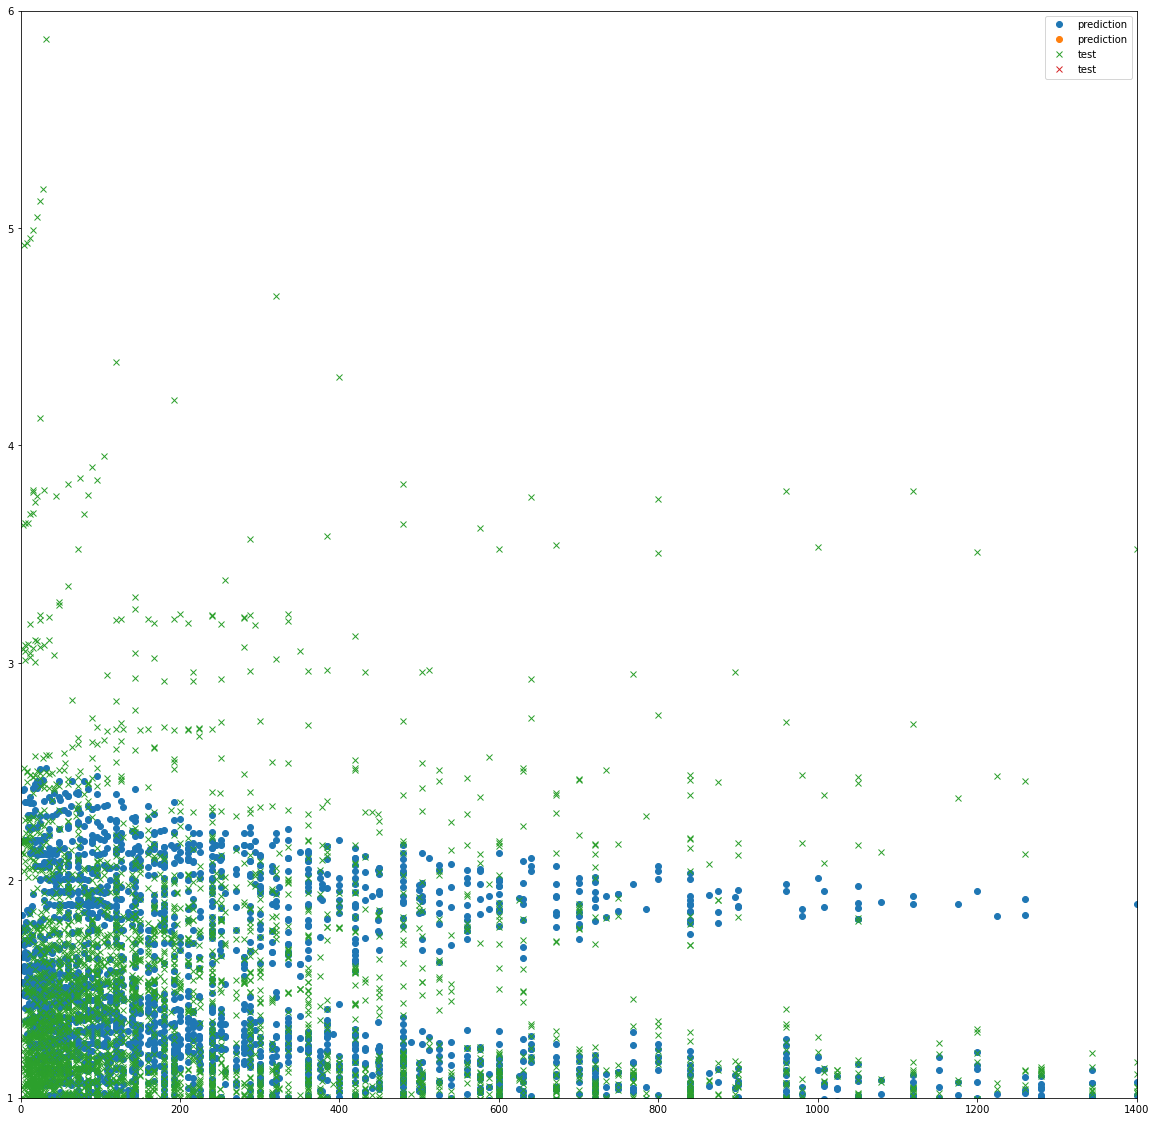

In [457]:
print("LINEAR REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT")
model = LinearRegression()
y_pred_lr, y_test_lr = _regressorAlgorithm(model, x_train_mo, x_test_mo, y_train_mo, y_test_mo)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_lr_mo_nd, y_test_lr_mo_nd = _regressorAlgorithm(model, x_train_mo_nd, x_test_mo_nd, y_train_mo_nd, y_test_mo_nd)

scatter_plot(t1_conf, y_pred_lr_mo_nd, y_test_lr_mo_nd)

KNEIGHBORS REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.06464150618735134
Mean Squared Error: 0.01891404574909596
Root Mean Squared Error: 0.13752834525688135
R2 score:  0.8638172883271156
Explained Variance Score:  0.8640174675772075
Mean Absolute Percentage Error:  46917541.18220624


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.1902622225527944
Mean Squared Error: 0.09043233018950564
Root Mean Squared Error: 0.30071968706671937
R2 score:  -0.1733536213547206
Explained Variance Score:  0.6061520302663269
Mean Absolute Percentage Error:  207.05301299852448


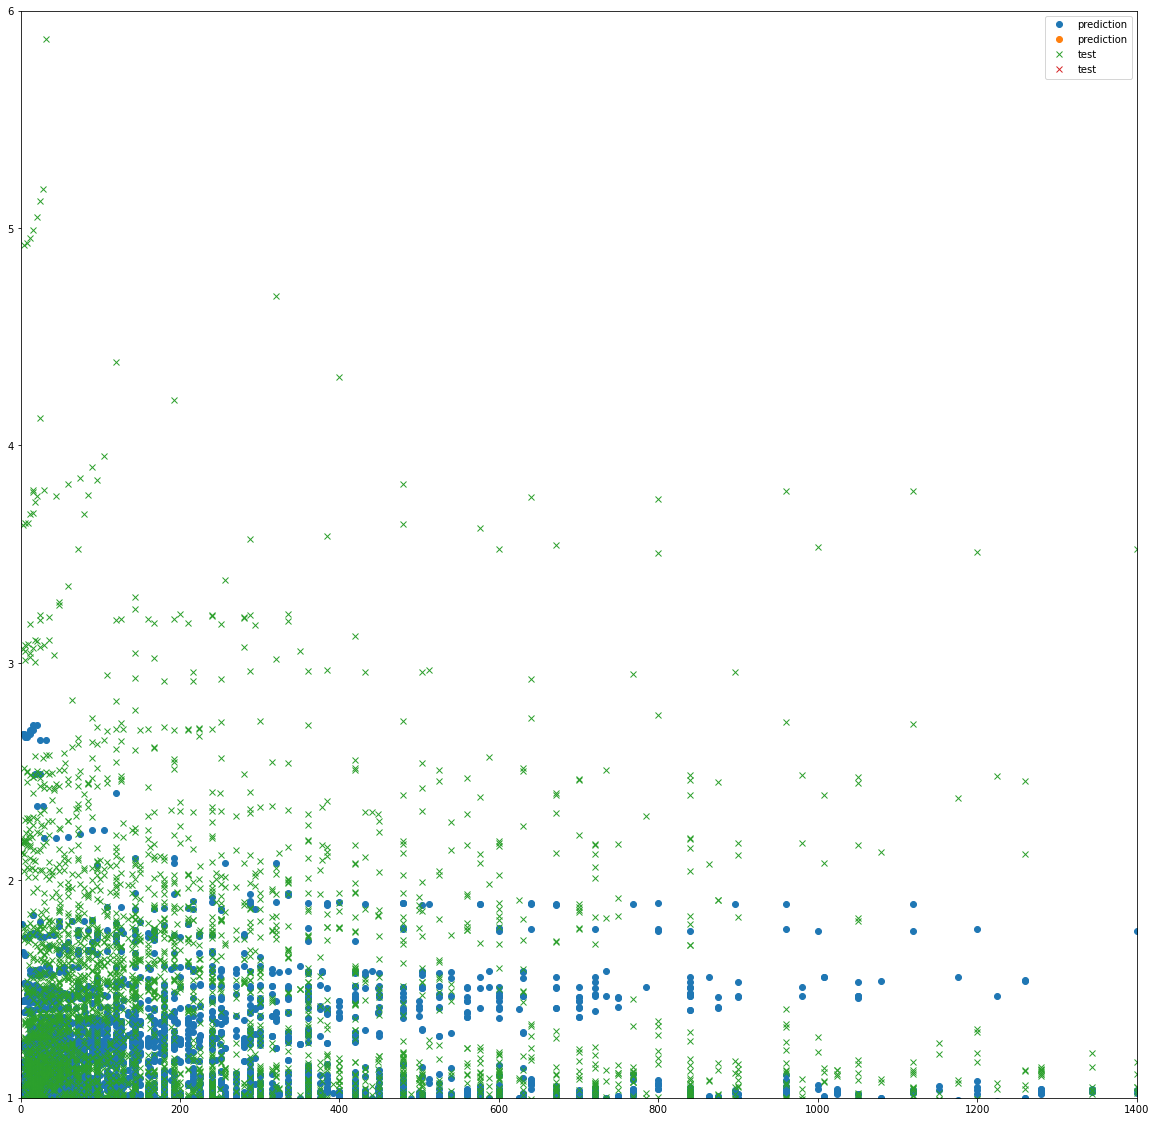

In [458]:
print("KNEIGHBORS REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT")
model = KNeighborsRegressor()
y_pred_knr, y_test_knr = _regressorAlgorithm(model, x_train_mo, x_test_mo, y_train_mo, y_test_mo)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_knr_mo_nd, y_test_knr_mo_nd = _regressorAlgorithm(model, x_train_mo_nd, x_test_mo_nd, y_train_mo_nd, y_test_mo_nd)
#_regressorAlgorithm_KFold(model, X_mo, y_mo)

scatter_plot(t1_conf, y_pred_knr_mo_nd, y_test_knr_mo_nd)

RANDOM FOREST REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.017427850046844585
Mean Squared Error: 0.004058123395841458
Root Mean Squared Error: 0.06370340176035702
R2 score:  0.9682087638552431
Explained Variance Score:  0.9682228903672372
Mean Absolute Percentage Error:  864846.8821902286


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.060806674326744234
Mean Squared Error: 0.013787971010562783
Root Mean Squared Error: 0.11742219130370027
R2 score:  0.9092751038234296
Explained Variance Score:  0.90944561249932
Mean Absolute Percentage Error:  57446.258766153835


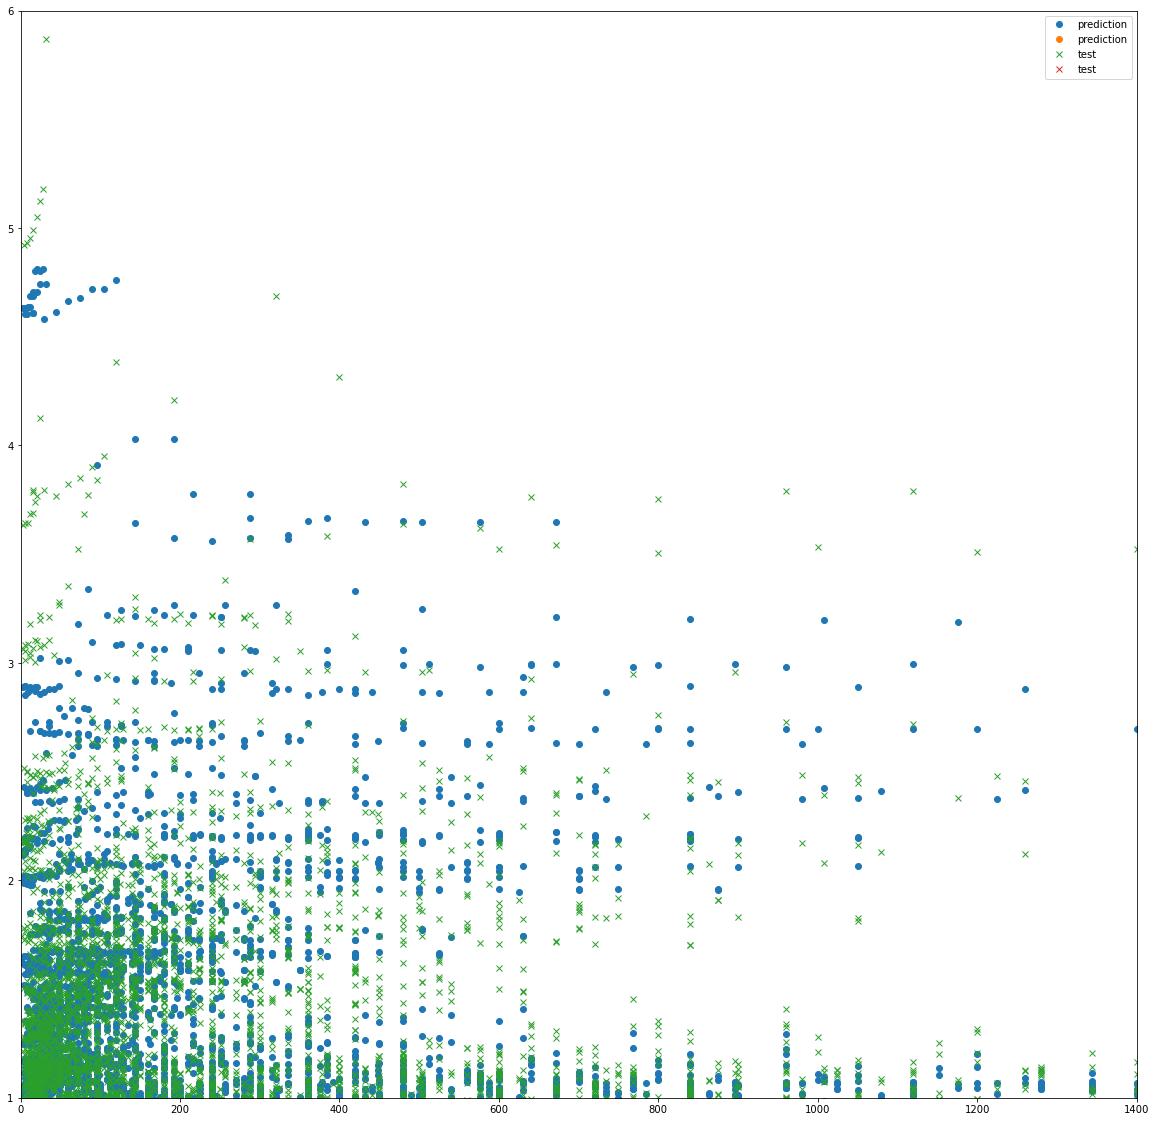

In [459]:
print("RANDOM FOREST REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT")
model = RandomForestRegressor(max_depth=1000, n_estimators=100, random_state=1)
y_pred_rfr, y_test_rfr = _regressorAlgorithm(model, x_train_mo, x_test_mo, y_train_mo, y_test_mo)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_rfr_mo_nd, y_test_rfr_mo_nd = _regressorAlgorithm(model, x_train_mo_nd, x_test_mo_nd, y_train_mo_nd, y_test_mo_nd)

scatter_plot(t1_conf, y_pred_rfr_mo_nd, y_test_rfr_mo_nd)

#_regressorAlgorithm_KFold(model, X_mo, y_mo)

DECISION TREE REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.01964604683472937
Mean Squared Error: 0.00475249177047943
Root Mean Squared Error: 0.06893831859335872
R2 score:  0.9634829464265464
Explained Variance Score:  0.9634921123715057
Mean Absolute Percentage Error:  133077.67752207344


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.06516400460249079
Mean Squared Error: 0.01879447098415826
Root Mean Squared Error: 0.13709292827917222
R2 score:  0.8910243365048796
Explained Variance Score:  0.891145345636775
Mean Absolute Percentage Error:  0.10287897748578281


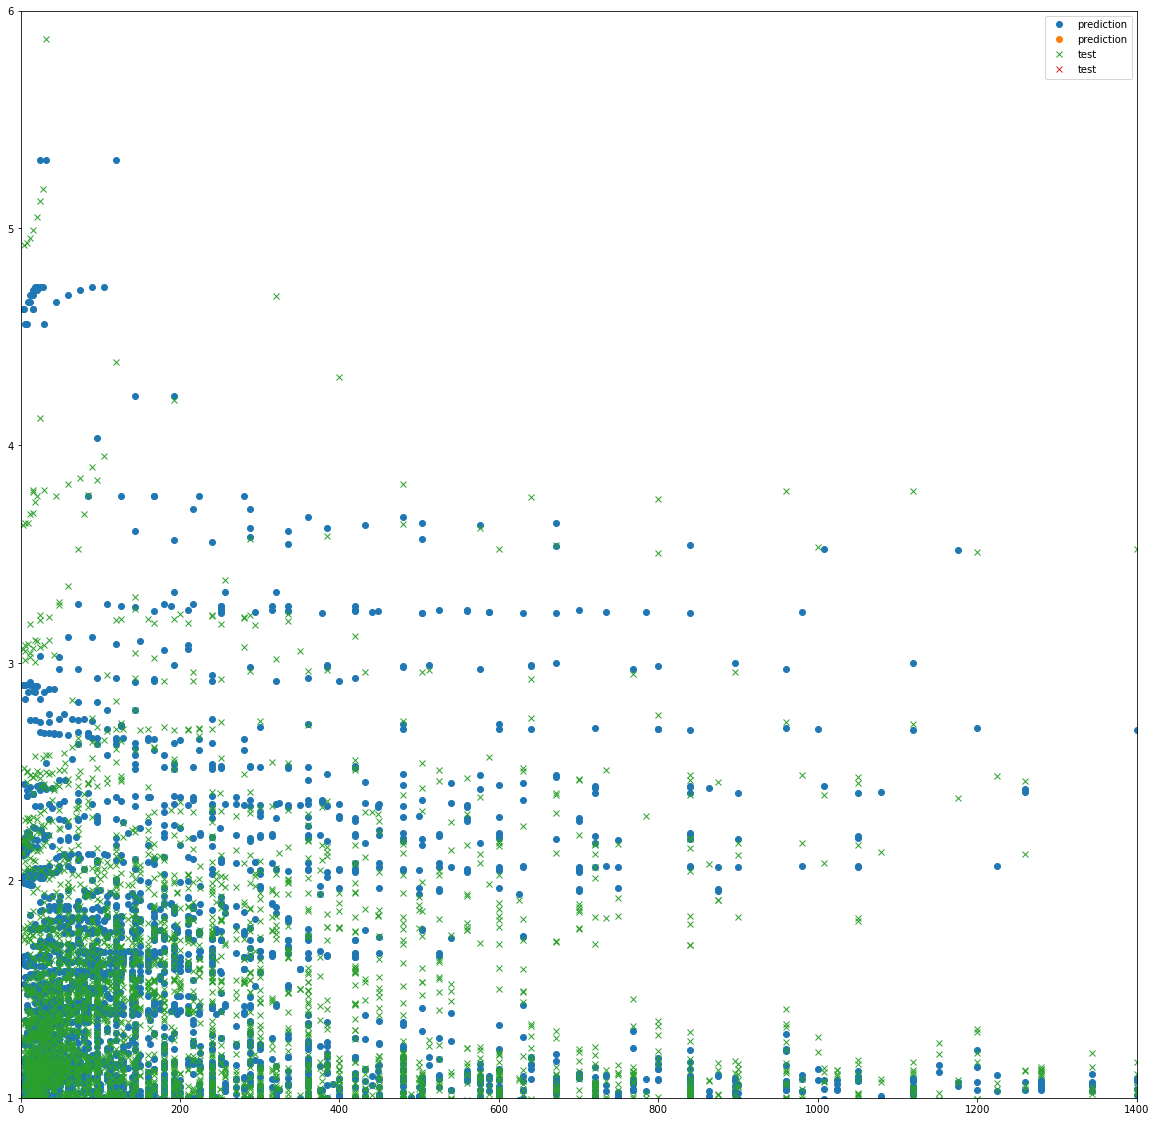

In [460]:
print("DECISION TREE REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT")
model = DecisionTreeRegressor(max_depth=1000, splitter="best", criterion="mse", min_samples_split=2)
y_pred_dtr, y_test_dtr = _regressorAlgorithm(model, x_train_mo, x_test_mo, y_train_mo, y_test_mo)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_dtr_mo_nd, y_test_dtr_mo_nd = _regressorAlgorithm(model, x_train_mo_nd, x_test_mo_nd, y_train_mo_nd, y_test_mo_nd)
#_regressorAlgorithm_KFold(model, X_mo, y_mo)

scatter_plot(t1_conf, y_pred_dtr_mo_nd, y_test_dtr_mo_nd)

MLP REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.15332885709099559
Mean Squared Error: 0.0571524904001166
Root Mean Squared Error: 0.2390658704209294
R2 score:  0.4753168039264612
Explained Variance Score:  0.4755573530394453
Mean Absolute Percentage Error:  294168988.5475758


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.1808621114688874
Mean Squared Error: 0.10286701305540531
Root Mean Squared Error: 0.32072887780086984
R2 score:  0.22530221551435892
Explained Variance Score:  0.30158921778722897
Mean Absolute Percentage Error:  202205244.1867743


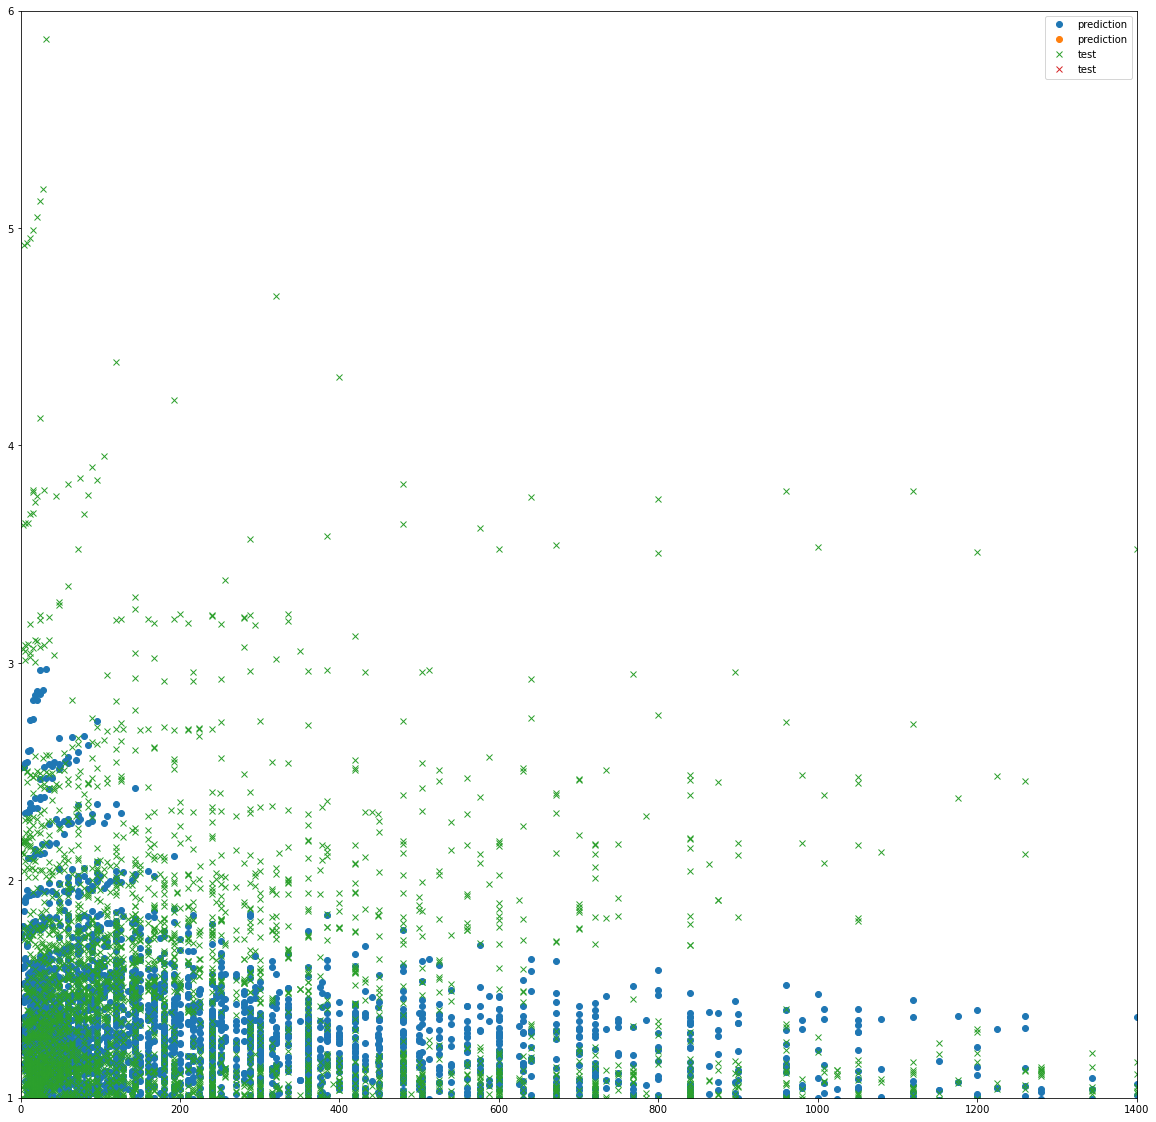

In [461]:
print("MLP REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT")
model = MLPRegressor(hidden_layer_sizes=(4,8,4),activation="relu" ,random_state=1, max_iter=50000)
y_pred_mlpr, y_test_mlpr = _regressorAlgorithm(model, x_train_mo, x_test_mo, y_train_mo, y_test_mo)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_mlpr_mo_nd, y_test_mlpr_mo_nd = _regressorAlgorithm(model, x_train_mo_nd, x_test_mo_nd, y_train_mo_nd, y_test_mo_nd)
#_regressorAlgorithm_KFold(model, X_mo, y_mo)

scatter_plot(t1_conf, y_pred_mlpr_mo_nd, y_test_mlpr_mo_nd)

In [462]:
print("MULTIOUTPUT REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT")
model = MultiOutputRegressor(Ridge(random_state=123))
y_pred_mor, y_test_mor = _regressorAlgorithm(model, x_train_mo, x_test_mo, y_train_mo, y_test_mo)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_mor_mo_nd, y_test_mor_mo_nd = _regressorAlgorithm(model, x_train_mo_nd, x_test_mo_nd, y_train_mo_nd, y_test_mo_nd)
#_regressorAlgorithm_KFold(model, X_mo, y_mo)


MULTIOUTPUT REGRESSION ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.1862266895734146
Mean Squared Error: 0.11406447106573608
Root Mean Squared Error: 0.3377343202366856
R2 score:  0.6198854614582318
Explained Variance Score:  0.6199638713536206
Mean Absolute Percentage Error:  109876944.82843132


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.2165629490508885
Mean Squared Error: 0.12190408984612588
Root Mean Squared Error: 0.3491476619513954
R2 score:  0.41782080871523136
Explained Variance Score:  0.5120188228261799
Mean Absolute Percentage Error:  40357800.77317609


SUPPORT VECTOR MACHINE ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.15009870186509025
Mean Squared Error: 0.10431845228343908
Root Mean Squared Error: 0.32298367185267907
R2 score:  0.6554174262177156
Explained Variance Score:  0.6639283082203882
Mean Absolute Percentage Error:  126436242.67487052


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.24000639668239232
Mean Squared Error: 0.13145047145262226
Root Mean Squared Error: 0.362560989976338
R2 score:  0.018461002496110546
Explained Variance Score:  0.12834277166055114
Mean Absolute Percentage Error:  138822753.4386256


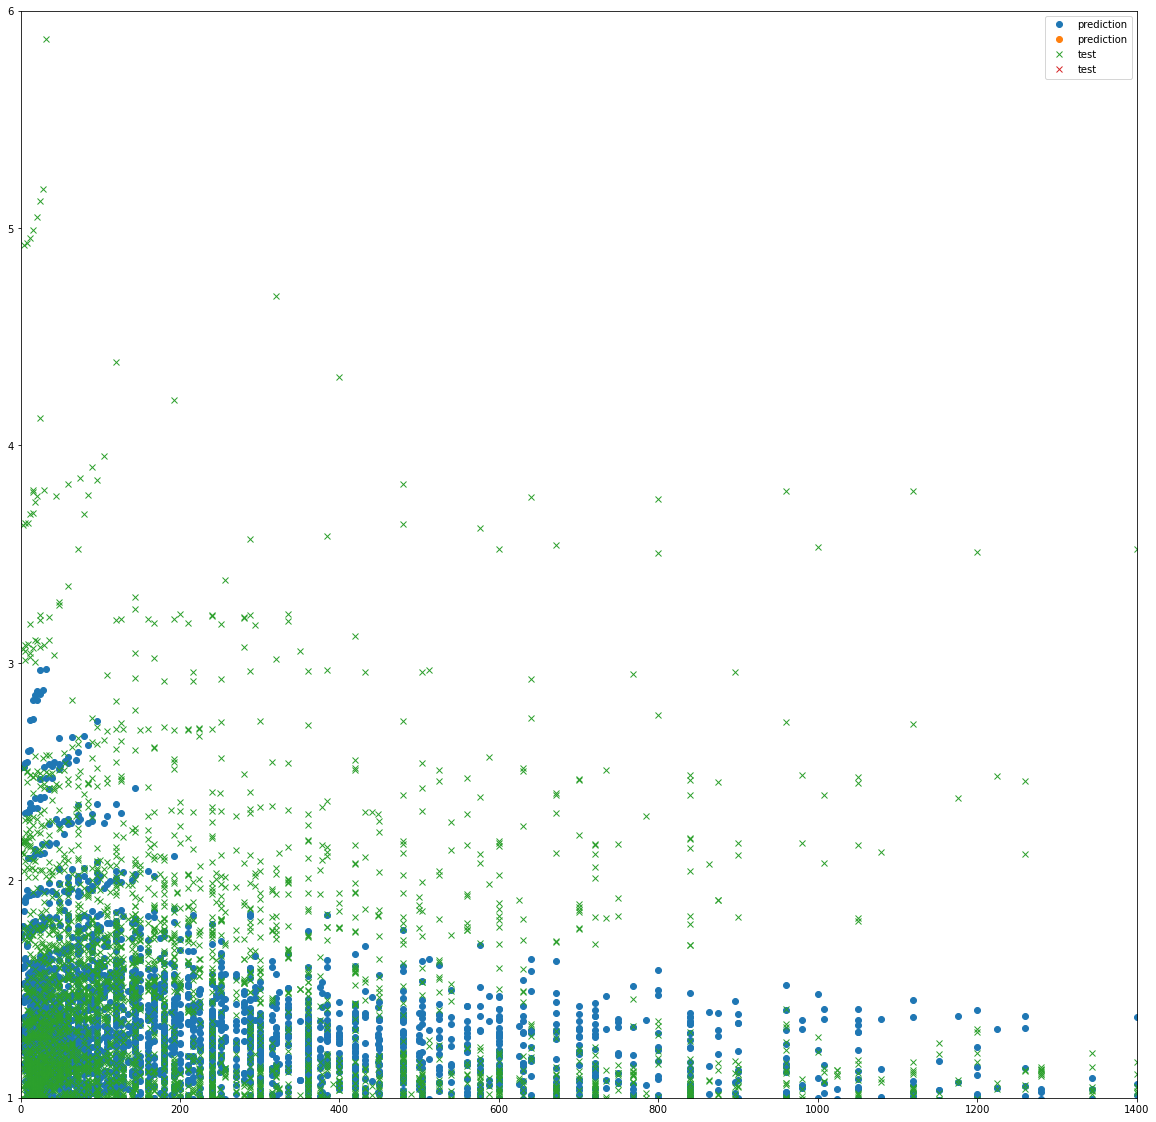

In [463]:
print("SUPPORT VECTOR MACHINE ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT")
model = MultiOutputRegressor(SVR())
y_pred_svm, y_test_svm = _regressorAlgorithm(model, x_train_mo, x_test_mo, y_train_mo, y_test_mo)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_svm_mo_nd, y_test_svm_mo_nd = _regressorAlgorithm(model, x_train_mo_nd, x_test_mo_nd, y_train_mo_nd, y_test_mo_nd)
#_regressorAlgorithm_KFold(model, X_mo, y_mo)

scatter_plot(t1_conf, y_pred_mlpr_mo_nd, y_test_mlpr_mo_nd)

GRADIENT BOOSTING REGRESSOR ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.06018541997753246
Mean Squared Error: 0.014623832538742046
Root Mean Squared Error: 0.12092903926990425
R2 score:  0.9368595815026467
Explained Variance Score:  0.9368690382487987
Mean Absolute Percentage Error:  3850741.6770332456


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.09709951798430443
Mean Squared Error: 0.03362006679101208
Root Mean Squared Error: 0.18335775628811582
R2 score:  0.8276028723013718
Explained Variance Score:  0.8279374126948147
Mean Absolute Percentage Error:  6972053.37145472


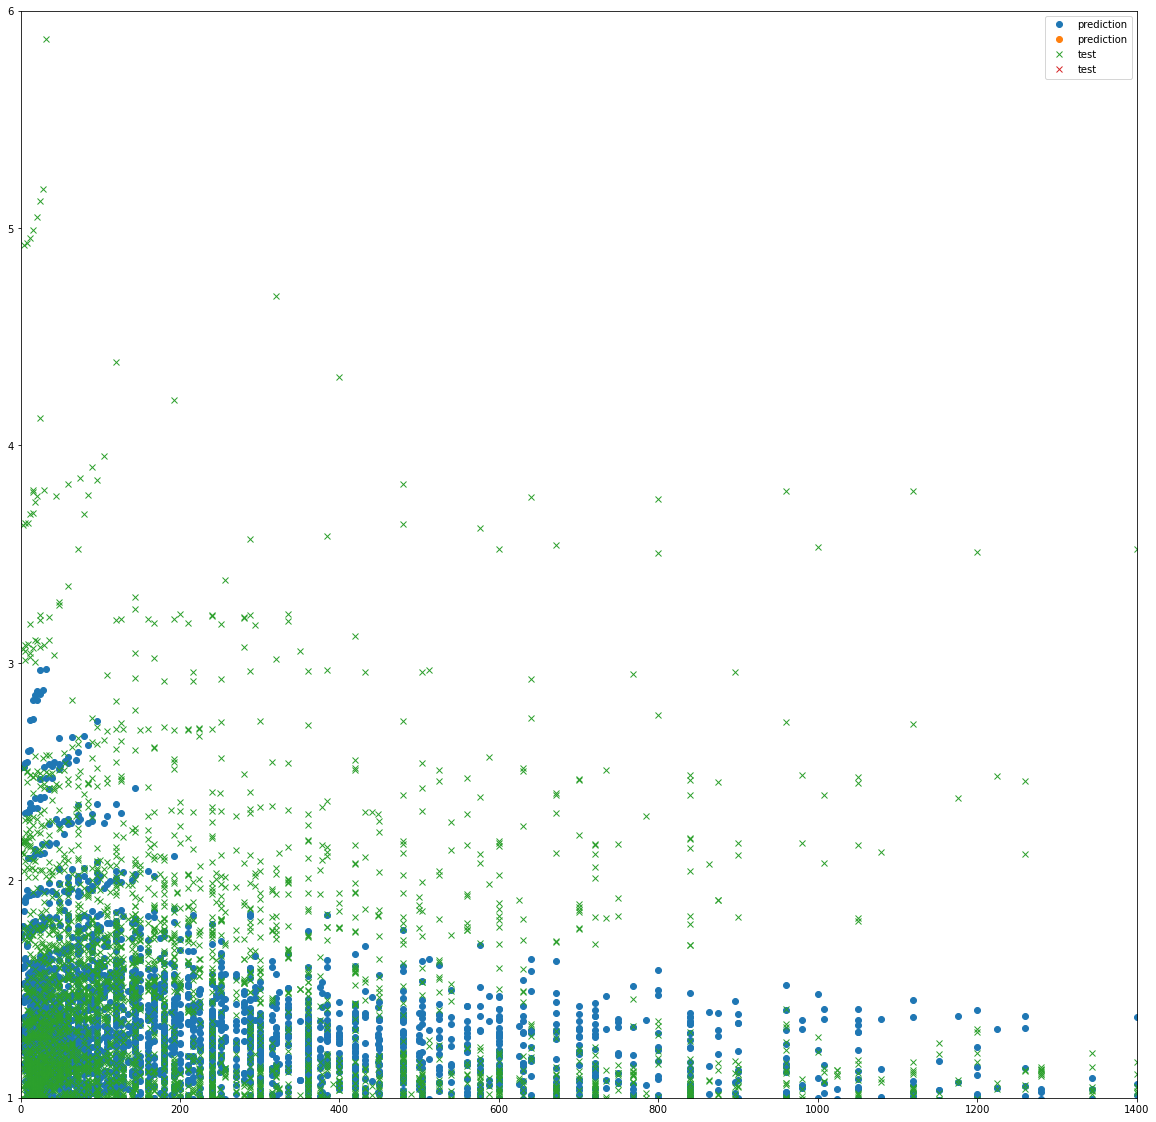

In [464]:
print("GRADIENT BOOSTING REGRESSOR ALGORITHM PERFORMANCE RESULTS ON MULTIPLE OUTPUT")
model = MultiOutputRegressor(GradientBoostingRegressor())
y_pred_gbr, y_test_gbr = _regressorAlgorithm(model, x_train_mo, x_test_mo, y_train_mo, y_test_mo)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_gbr_mo_nd, y_test_gbr_mo_nd = _regressorAlgorithm(model, x_train_mo_nd, x_test_mo_nd, y_train_mo_nd, y_test_mo_nd)
#_regressorAlgorithm_KFold(model, X_mo, y_mo)

scatter_plot(t1_conf, y_pred_mlpr_mo_nd, y_test_mlpr_mo_nd)

# Predict Single Output - Execution

In [465]:
X_sox = df1.drop(['speedup', 'Error'],axis=1)
y_sox = df1[['speedup']]
X_sox = X_sox.values

#split the data randomly
x_train_sox, x_test_sox, y_train_sox, y_test_sox = train_test_split(X_sox, y_sox, test_size=0.2, random_state=13)

#split data - small graphs for training, large graphs for testing
a = df1.loc[(df1['graphSize'] != 32) | (df1['sOriginalDistance'] == 1)]
b = df1.loc[(df1['graphSize'] == 32) & (df1['sOriginalDistance'] == 0)]
x_train_sox_nd = a.drop(['speedup', 'Error'],axis=1)
y_train_sox_nd = a[['speedup']]
x_test_sox_nd = b.drop(['speedup', 'Error'],axis=1)
y_test_sox_nd = b[['speedup']]

t1 = x_test_sox_nd.copy()
t1_conf = conf_preprocess(t1)

LINEAR REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.3246303449765465
Mean Squared Error: 0.22427425839866427
Root Mean Squared Error: 0.4735760323313082
R2 score:  0.5648783608450971
Explained Variance Score:  0.56494914077667
Mean Absolute Percentage Error:  0.22948310612641


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.37922915519219486
Mean Squared Error: 0.2389192835618136
Root Mean Squared Error: 0.4887937024571957
R2 score:  0.23891531229178686
Explained Variance Score:  0.3968474510575729
Mean Absolute Percentage Error:  0.2978548419799965


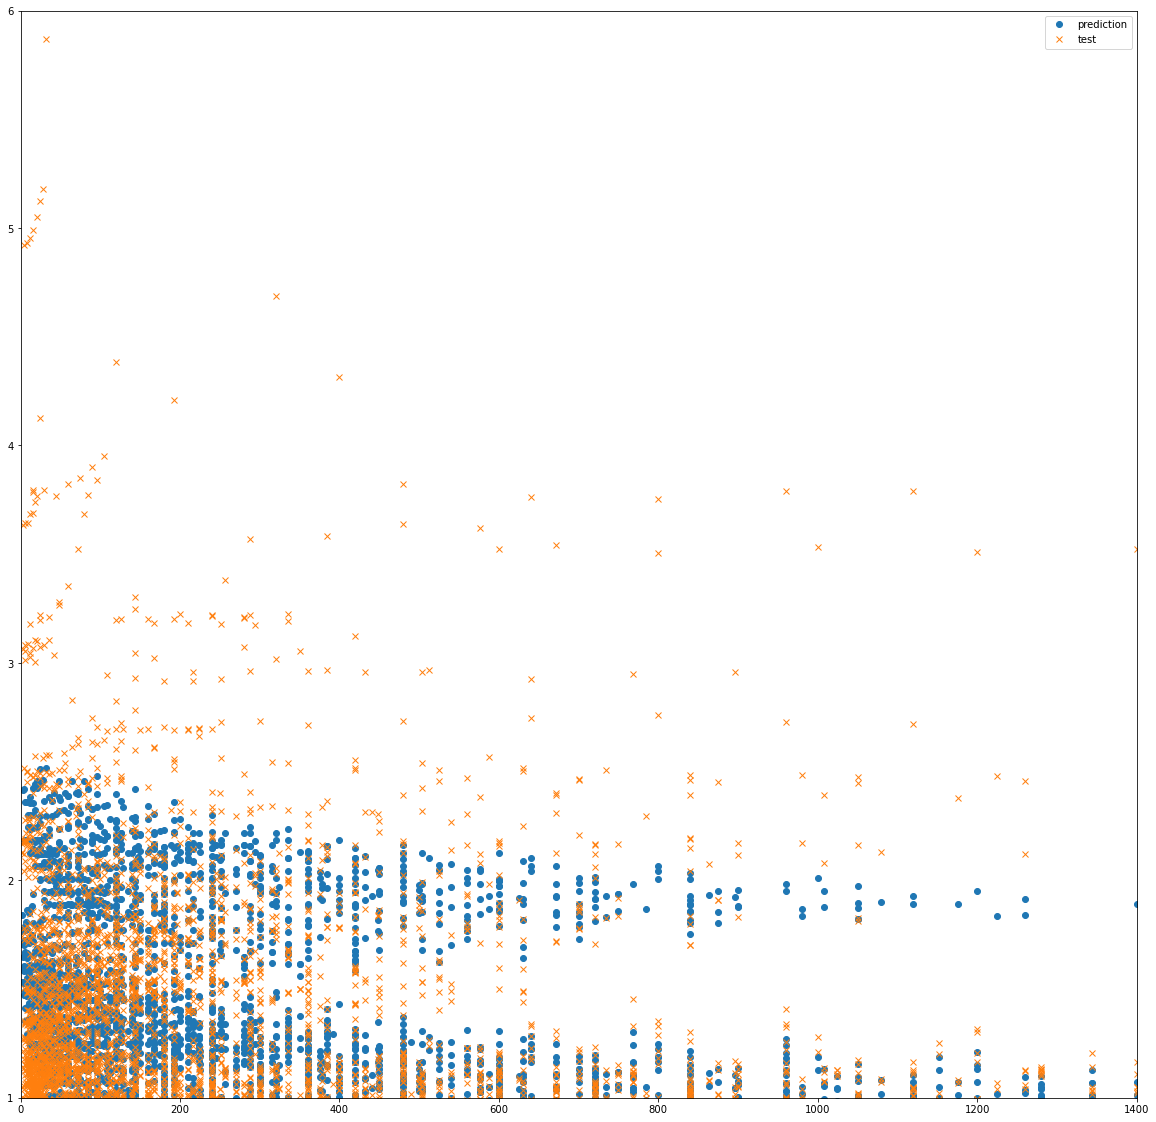

In [466]:
print("LINEAR REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION")
model = LinearRegression()
y_pred_lr_sox, y_test_lr_sox = _regressorAlgorithm(model, x_train_sox, x_test_sox, y_train_sox, y_test_sox)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_lr_sox_nd, y_test_lr_sox_nd = _regressorAlgorithm(model, x_train_sox_nd, x_test_sox_nd, y_train_sox_nd, y_test_sox_nd)
#_regressorAlgorithm_KFold(model, X_sox, y_sox)

lrsox = np.abs(y_pred_lr_sox_nd - y_test_lr_sox_nd).to_numpy()

scatter_plot(t1_conf, y_pred_lr_sox_nd, y_test_lr_sox_nd)

KNEIGHBORS REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.09155524724467921
Mean Squared Error: 0.035411846789491136
Root Mean Squared Error: 0.1881803570766384
R2 score:  0.9312963470236697
Explained Variance Score:  0.9313621303989904
Mean Absolute Percentage Error:  0.05624217250424087


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.24843350980068232
Mean Squared Error: 0.15829576831680237
Root Mean Squared Error: 0.3978640073150653
R2 score:  0.4957439868441791
Explained Variance Score:  0.640742340139488
Mean Absolute Percentage Error:  0.14651898539153901


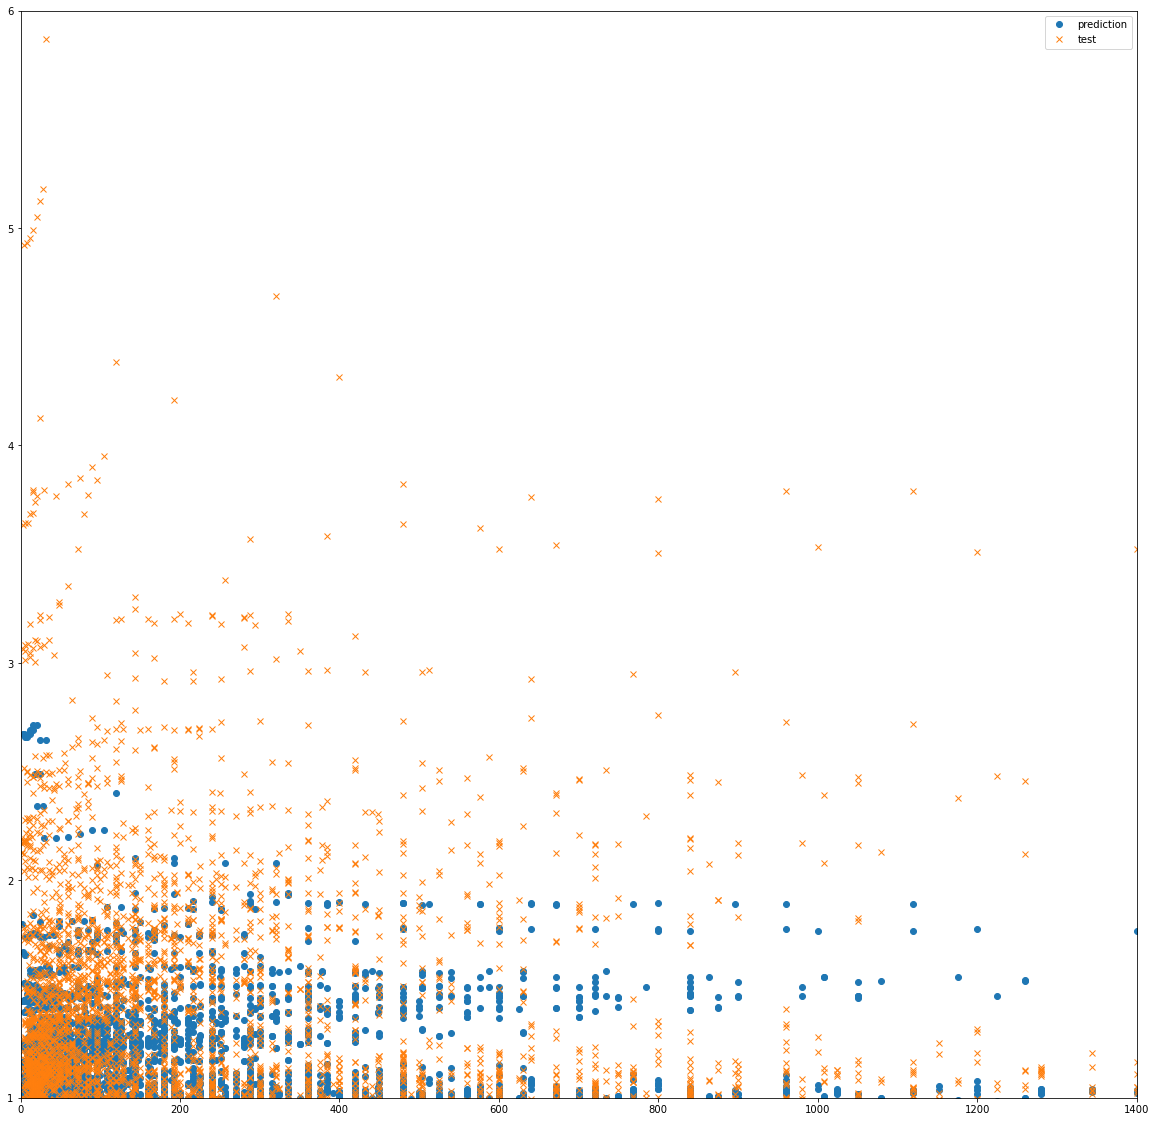

In [467]:
print("KNEIGHBORS REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION")
model = KNeighborsRegressor()
y_pred_knr_sox, y_test_knr_sox = _regressorAlgorithm(model, x_train_sox, x_test_sox, y_train_sox, y_test_sox)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_knr_sox_nd, y_test_knr_sox_nd = _regressorAlgorithm(model, x_train_sox_nd, x_test_sox_nd, y_train_sox_nd, y_test_sox_nd)
#_regressorAlgorithm_KFold(model, X_sox, y_sox)

knrsox = np.abs(y_pred_knr_sox_nd - y_test_knr_sox_nd).to_numpy()

scatter_plot(t1_conf, y_pred_knr_sox_nd, y_test_knr_sox_nd)

RANDOM FOREST REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION


<ipython-input-450-9ee3b5a821a3>:75: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.02634359939441774
Mean Squared Error: 0.007466405839053462
Root Mean Squared Error: 0.08640836671904788
R2 score:  0.9855141879835817
Explained Variance Score:  0.9855246654181755
Mean Absolute Percentage Error:  0.017648691096594272


--- small graphs for training, large graphs for testing ---


<ipython-input-450-9ee3b5a821a3>:75: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.09836605525931777
Mean Squared Error: 0.0262804052260571
Root Mean Squared Error: 0.16211232286922886
R2 score:  0.9162829650828745
Explained Variance Score:  0.9163648823937252
Mean Absolute Percentage Error:  0.0632170378803528


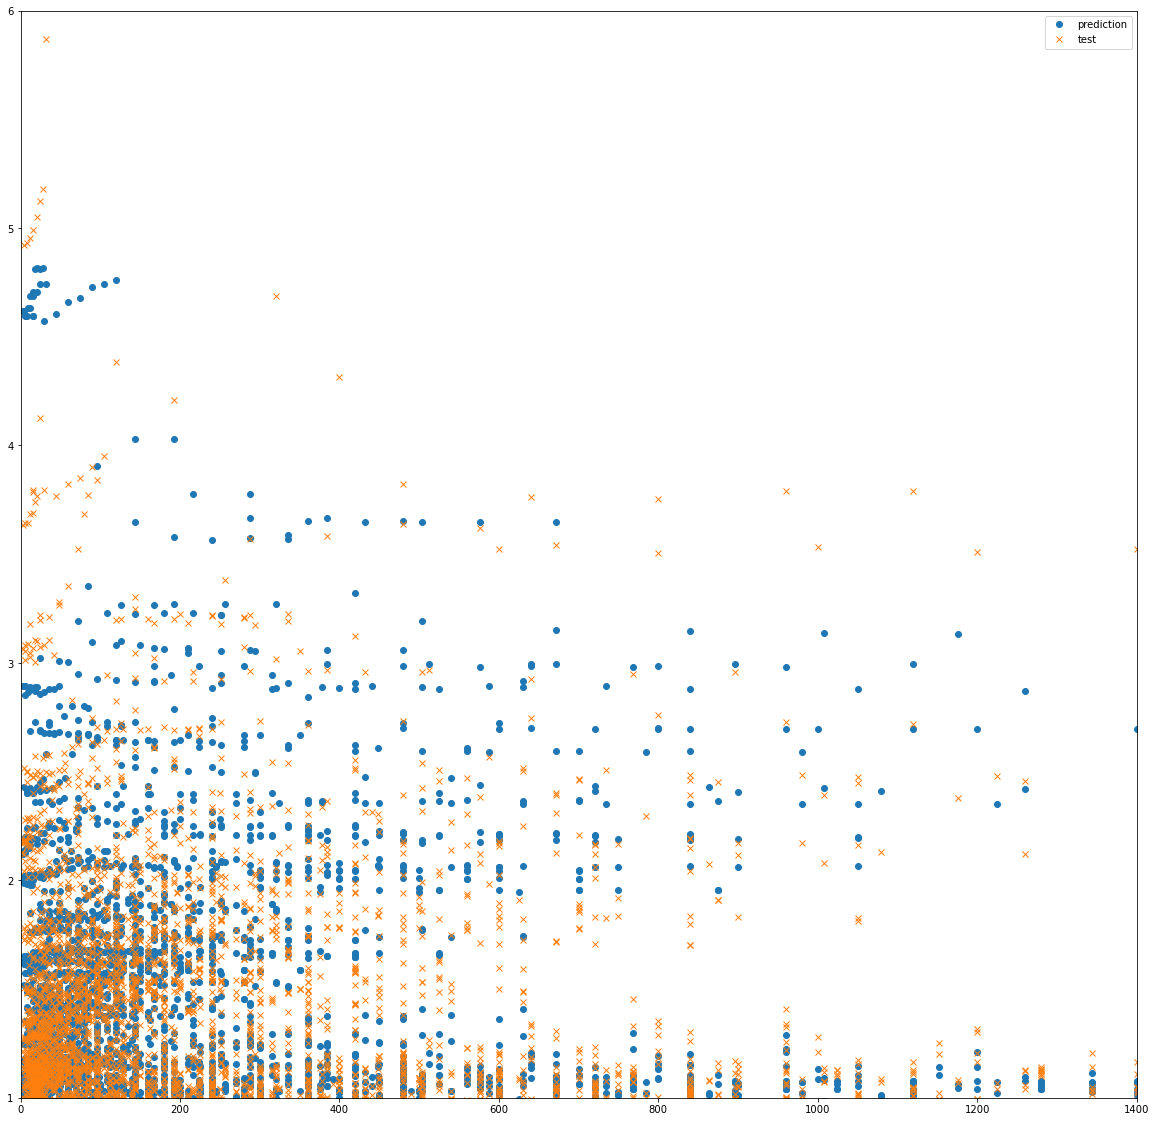

In [469]:
print("RANDOM FOREST REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION")
model = RandomForestRegressor(max_depth=1000, n_estimators=100, random_state=1)
y_pred_rfr_sox, y_test_rfr_sox = _regressorAlgorithm(model, x_train_sox, x_test_sox, y_train_sox, y_test_sox)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_rfr_sox_nd, y_test_rfr_sox_nd = _regressorAlgorithm(model, x_train_sox_nd, x_test_sox_nd, y_train_sox_nd, y_test_sox_nd)
#_regressorAlgorithm_KFold(model, X_sox, y_sox)

scatter_plot(t1_conf, y_pred_rfr_sox_nd, y_test_rfr_sox_nd)

DECISION TREE REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.02976718984941483
Mean Squared Error: 0.008954292258762988
Root Mean Squared Error: 0.0946271222153722
R2 score:  0.9826274921030874
Explained Variance Score:  0.9826451641880419
Mean Absolute Percentage Error:  0.0202393262321749


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.10662099556539004
Mean Squared Error: 0.03604593701324787
Root Mean Squared Error: 0.18985767567640732
R2 score:  0.8851745647907072
Explained Variance Score:  0.8851785711721746
Mean Absolute Percentage Error:  0.06750497624081865
[2.13613621 1.05221822 1.00198977 0.99584561 1.00360775 0.99996672
 1.00246734 1.01864243 1.04557429 1.08785035 1.10445703 1.12505949
 1.15975967 1.19089074 0.99820584 1.31919487 1.31919487 1.31919487
 1.44335708 1.3430526 ]
    

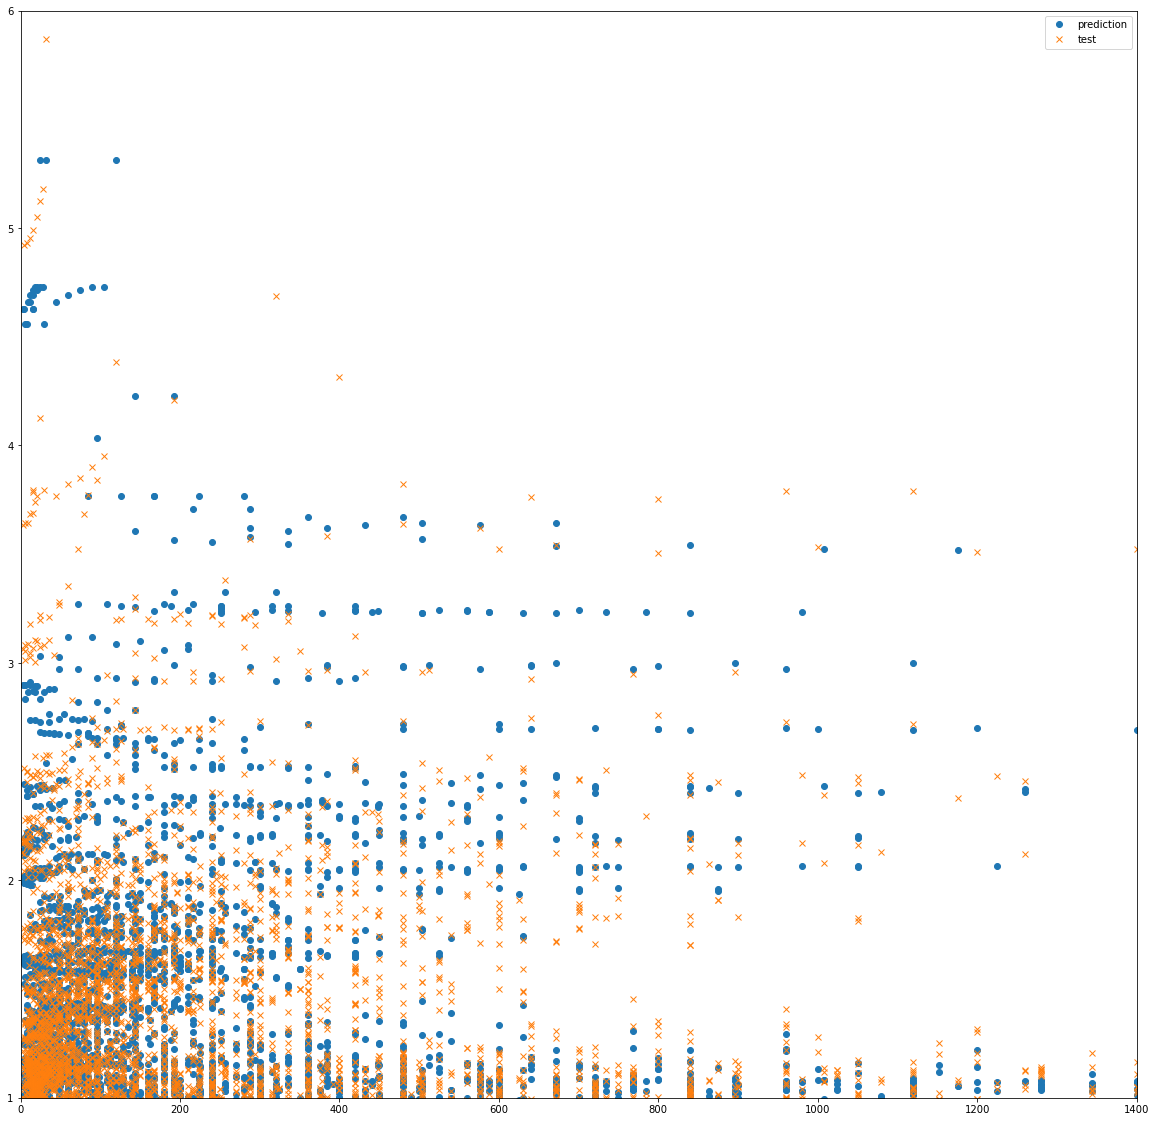

In [471]:
print("DECISION TREE REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION")
model = DecisionTreeRegressor(max_depth=1000, splitter="best", criterion="mse", min_samples_split=2)
y_pred_dtr_sox, y_test_dtr_sox = _regressorAlgorithm(model, x_train_sox, x_test_sox, y_train_sox, y_test_sox)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_dtr_sox_nd, y_test_dtr_sox_nd = _regressorAlgorithm(model, x_train_sox_nd, x_test_sox_nd, y_train_sox_nd, y_test_sox_nd)
print(y_pred_dtr_sox_nd[:20])
print(y_test_dtr_sox_nd.head(20))
#_regressorAlgorithm_KFold(model, X_sox, y_sox)

scatter_plot(t1_conf, y_pred_dtr_sox_nd, y_test_dtr_sox_nd)

MLP REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION


/home/buse/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.1795904406528777
Mean Squared Error: 0.0843195741331671
Root Mean Squared Error: 0.29037832931051705
R2 score:  0.8364089059010549
Explained Variance Score:  0.8372189838354618
Mean Absolute Percentage Error:  0.11576327731343537


--- small graphs for training, large graphs for testing ---


/home/buse/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.24791338133051127
Mean Squared Error: 0.1716370771452377
Root Mean Squared Error: 0.414291053663047
R2 score:  0.4532448393834363
Explained Variance Score:  0.47521846137491264
Mean Absolute Percentage Error:  0.15843243660104503


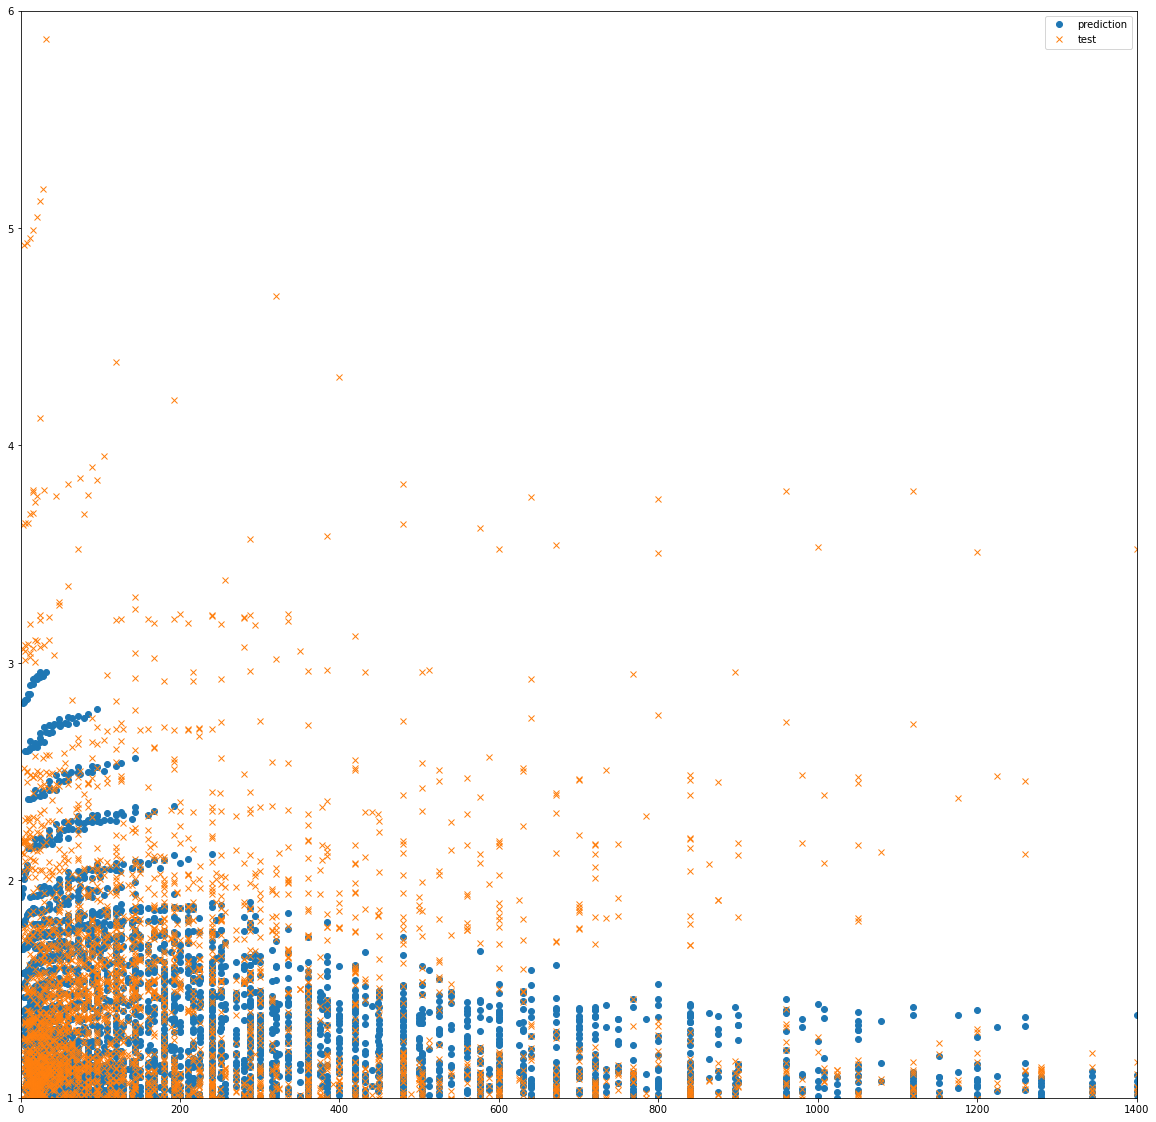

In [472]:
print("MLP REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION")
model = MLPRegressor(hidden_layer_sizes=(4,8,4),activation="relu" ,random_state=1, max_iter=50000)
y_pred_mlpr_sox, y_test_mlpr_sox = _regressorAlgorithm(model, x_train_sox, x_test_sox, y_train_sox, y_test_sox)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_mlpr_sox_nd, y_test_mlpr_sox_nd = _regressorAlgorithm(model, x_train_sox_nd, x_test_sox_nd, y_train_sox_nd, y_test_sox_nd)
#_regressorAlgorithm_KFold(model, X_sox, y_sox)

scatter_plot(t1_conf, y_pred_mlpr_sox_nd, y_test_mlpr_sox_nd)

MULTIOUTPUT REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.324597777614961
Mean Squared Error: 0.22427180876418562
Root Mean Squared Error: 0.4735734460083099
R2 score:  0.5648831134590497
Explained Variance Score:  0.5649537719937826
Mean Absolute Percentage Error:  0.22944541954227274


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.3791740374545506
Mean Squared Error: 0.2388662563017538
Root Mean Squared Error: 0.4887394564609592
R2 score:  0.23908423225111786
Explained Variance Score:  0.39694659967443524
Mean Absolute Percentage Error:  0.29778658781441636


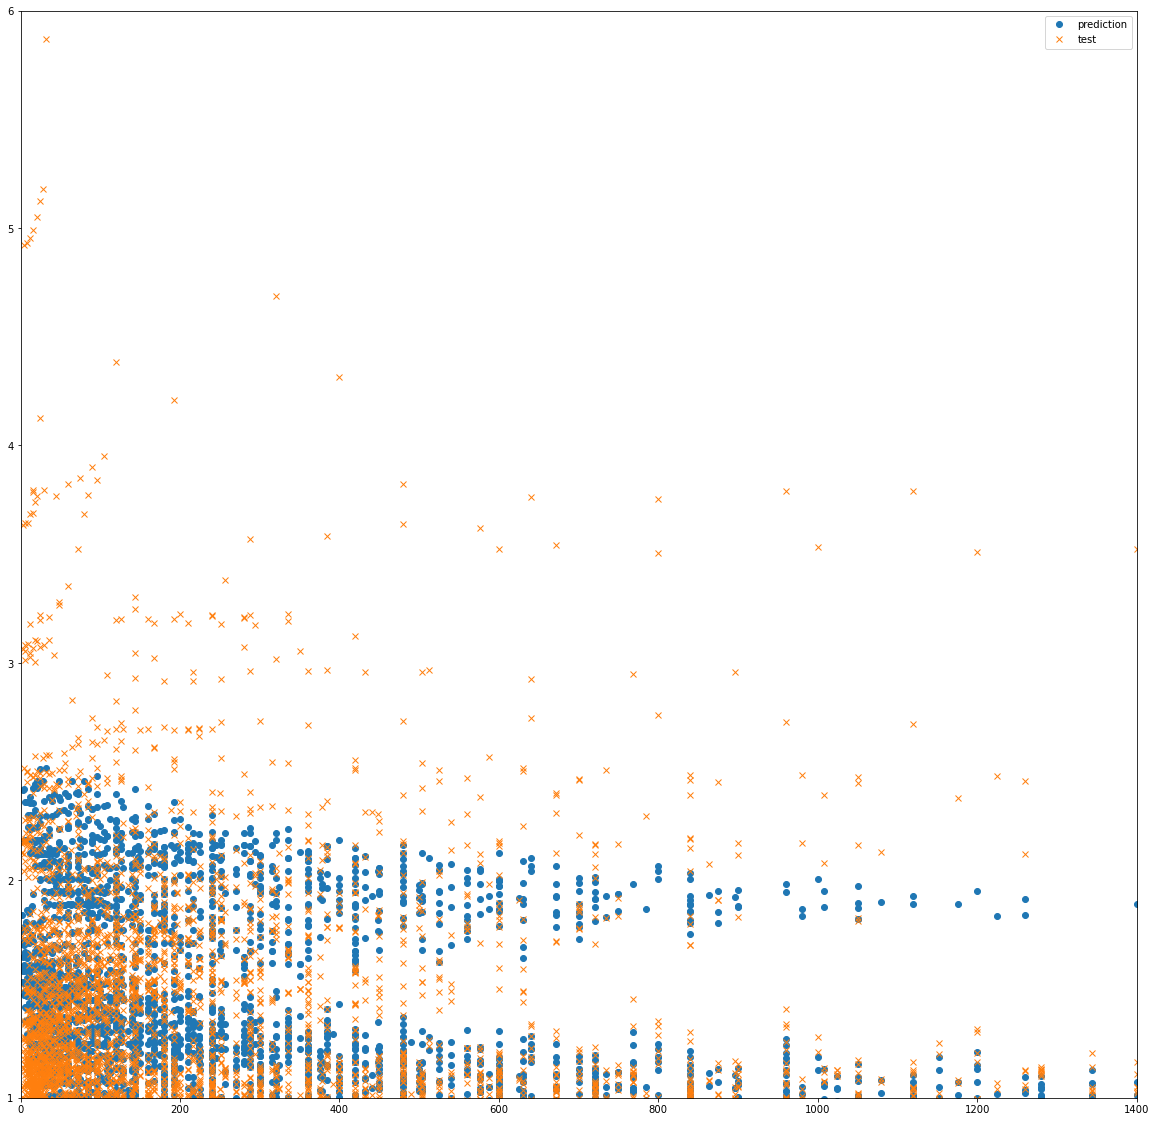

In [474]:
print("MULTIOUTPUT REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION")
model = MultiOutputRegressor(Ridge(random_state=123))
y_pred_mor_sox, y_test_mor_sox = _regressorAlgorithm(model, x_train_sox, x_test_sox, y_train_sox, y_test_sox)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_mor_sox_nd, y_test_mor_sox_nd = _regressorAlgorithm(model, x_train_sox_nd, x_test_sox_nd, y_train_sox_nd, y_test_sox_nd)
#_regressorAlgorithm_KFold(model, X_sox, y_sox)

scatter_plot(t1_conf, y_pred_mor_sox_nd, y_test_mor_sox_nd)

SVM ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION


/home/buse/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.25191339919103933
Mean Squared Error: 0.20518350457423215
Root Mean Squared Error: 0.45297185847934546
R2 score:  0.601916941001825
Explained Variance Score:  0.6090428803076733
Mean Absolute Percentage Error:  0.15206384960825303


--- small graphs for training, large graphs for testing ---


/home/buse/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.37725182013498765
Mean Squared Error: 0.24855318821463213
Root Mean Squared Error: 0.4985510888711729
R2 score:  0.20822621426339738
Explained Variance Score:  0.20990453952326138
Mean Absolute Percentage Error:  0.2865753542219227


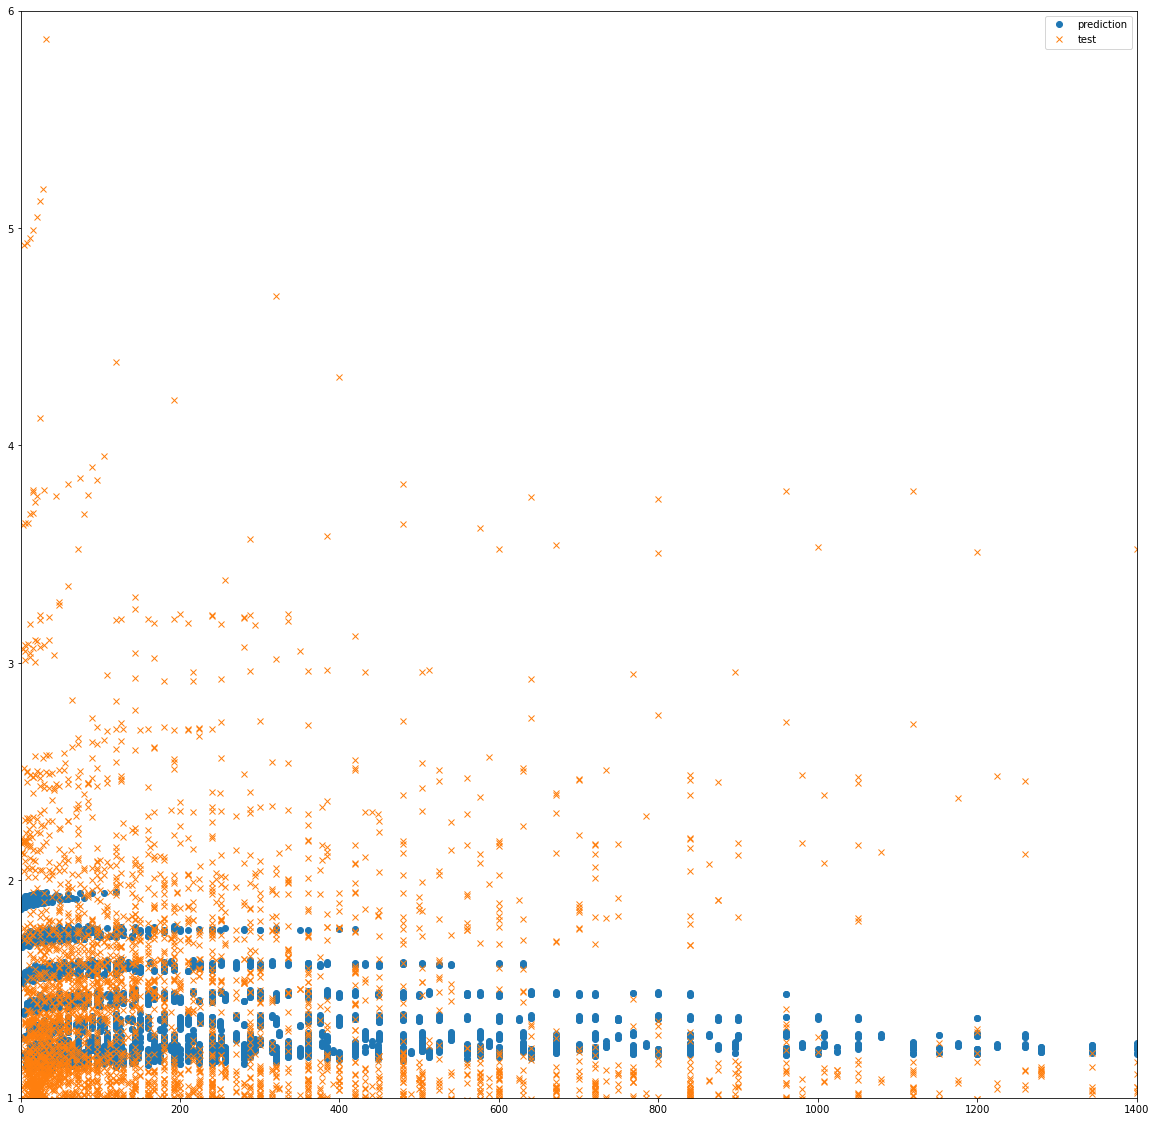

In [475]:
print("SVM ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION")
model = SVR()
y_pred_svm_sox, y_test_svm_sox = _regressorAlgorithm(model, x_train_sox, x_test_sox, y_train_sox, y_test_sox)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_svm_sox_nd, y_test_svm_sox_nd = _regressorAlgorithm(model, x_train_sox_nd, x_test_sox_nd, y_train_sox_nd, y_test_sox_nd)
#_regressorAlgorithm_KFold(model, X_sox, y_sox)

scatter_plot(t1_conf, y_pred_svm_sox_nd, y_test_svm_sox_nd)

GRADIENT BOOSTING ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION


/home/buse/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.10066013970551224
Mean Squared Error: 0.028403246830218606
Root Mean Squared Error: 0.16853262838459088
R2 score:  0.9448939552567054
Explained Variance Score:  0.9448943149853086
Mean Absolute Percentage Error:  0.06578604883179824


--- small graphs for training, large graphs for testing ---


/home/buse/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.16288108317846883
Mean Squared Error: 0.06557542095425921
Root Mean Squared Error: 0.25607698247647953
R2 score:  0.7911074902189945
Explained Variance Score:  0.7913751999832355
Mean Absolute Percentage Error:  0.10388489294516075


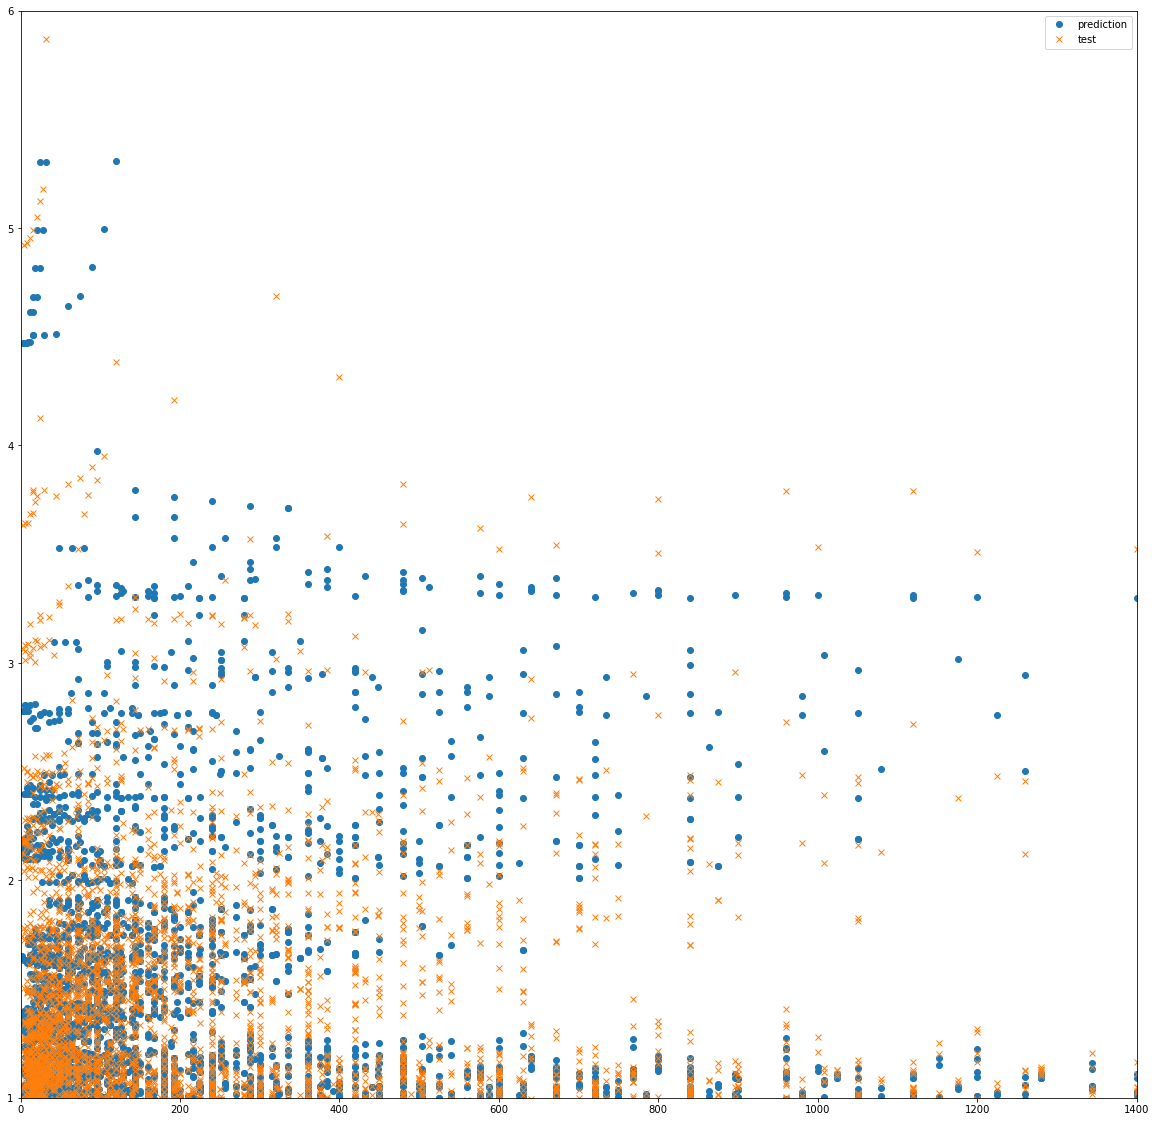

In [477]:
print("GRADIENT BOOSTING ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT EXECUTION")
model = GradientBoostingRegressor()
y_pred_gbc_sox, y_test_gbc_sox = _regressorAlgorithm(model, x_train_sox, x_test_sox, y_train_sox, y_test_sox)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_gbc_sox_nd, y_test_gbc_sox_nd = _regressorAlgorithm(model, x_train_sox_nd, x_test_sox_nd, y_train_sox_nd, y_test_sox_nd)
#_regressorAlgorithm_KFold(model, X_sox, y_sox)

scatter_plot(t1_conf, y_pred_gbc_sox_nd, y_test_gbc_sox_nd)

# Predict Single Output - Error 

In [478]:
X_soe = df1.drop(['speedup', 'Error'],axis=1)
y_soe = df1[['Error']]
X_soe = X_soe.values

#split the data randomly
x_train_soe, x_test_soe, y_train_soe, y_test_soe = train_test_split(X_soe, y_soe, test_size=0.2, random_state=13)

#split data - small graphs for training, large graphs for testing
a = df1.loc[(df1['graphSize'] != 32) | (df1['sOriginalDistance'] == 1)]
b = df1.loc[(df1['graphSize'] == 32) & (df1['sOriginalDistance'] == 0)]
x_train_soe_nd = a.drop(['speedup', 'Error'],axis=1)
y_train_soe_nd = a[['Error']]
x_test_soe_nd = b.drop(['speedup', 'Error'],axis=1)
y_test_soe_nd = b[['Error']]

In [479]:
print("LINEAR REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR")
model = LinearRegression()
y_pred_lr_soe, y_test_lr_soe = _regressorAlgorithm(model, x_train_soe, x_test_soe, y_train_soe, y_test_soe)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_lr_soe_nd, y_test_lr_soe_nd = _regressorAlgorithm(model, x_train_soe_nd, x_test_soe_nd, y_train_soe_nd, y_test_soe_nd)
#_regressorAlgorithm_KFold(model, X_soe, y_soe)
print(type(y_pred_lr_soe_nd))

LINEAR REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.047850201568287794
Mean Squared Error: 0.0038574400522258683
Root Mean Squared Error: 0.062108292942455505
R2 score:  0.6748619594276298
Explained Variance Score:  0.6749481399728485
Mean Absolute Percentage Error:  218698823.74762404


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.053954011184730484
Mean Squared Error: 0.004944236071746424
Root Mean Squared Error: 0.07031526201150376
R2 score:  0.5963685853748177
Explained Variance Score:  0.626953407925897
Mean Absolute Percentage Error:  80768601.08390734
<class 'numpy.ndarray'>


In [480]:
print("KNEIGHBORS REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR")
model = KNeighborsRegressor()
y_pred_knr_soe, y_test_knr_soe = _regressorAlgorithm(model, x_train_soe, x_test_soe, y_train_soe, y_test_soe)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_knr_soe_nd, y_test_knr_soe_nd = _regressorAlgorithm(model, x_train_soe_nd, x_test_soe_nd, y_train_soe_nd, y_test_soe_nd)
#_regressorAlgorithm_KFold(model, X_soe, y_soe)
print(type(y_pred_knr_soe_nd))

KNEIGHBORS REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.03772776513002364
Mean Squared Error: 0.002416244708700686
Root Mean Squared Error: 0.04915531211070362
R2 score:  0.7963382296305619
Explained Variance Score:  0.7966728047554247
Mean Absolute Percentage Error:  93835082.30817015


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.132090935304906
Mean Squared Error: 0.022568892062209325
Root Mean Squared Error: 0.15022946469387863
R2 score:  -0.842451229553628
Explained Variance Score:  0.571561720393165
Mean Absolute Percentage Error:  413.9595070116582
<class 'numpy.ndarray'>


In [481]:
print("RANDOM FOREST REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR")
model = RandomForestRegressor(max_depth=1000, n_estimators=100, random_state=1)
y_pred_rfr_soe, y_test_rfr_soe = _regressorAlgorithm(model, x_train_soe, x_test_soe, y_train_soe.values.ravel(), y_test_soe)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_rfr_soe_nd, y_test_rfr_soe_nd = _regressorAlgorithm(model, x_train_soe_nd, x_test_soe_nd, y_train_soe_nd.values.ravel(), y_test_soe_nd)
#_regressorAlgorithm_KFold(model, X_soe, y_soe)

RANDOM FOREST REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.004972416629978965
Mean Squared Error: 0.0005294909560912764
Root Mean Squared Error: 0.023010670483305705
R2 score:  0.955369973445221
Explained Variance Score:  0.9553812153857817
Mean Absolute Percentage Error:  2653.715928313344


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.02423664806051114
Mean Squared Error: 0.0012266708482285406
Root Mean Squared Error: 0.035023861126788125
R2 score:  0.8998585661029999
Explained Variance Score:  0.8998914883779862
Mean Absolute Percentage Error:  16.18725340087189


In [482]:
print("DECISION TREE REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR")
model = DecisionTreeRegressor(max_depth=1000, splitter="best", criterion="mse", min_samples_split=2)
y_pred_dtr_soe, y_test_dtr_soe = _regressorAlgorithm(model, x_train_soe, x_test_soe, y_train_soe, y_test_soe)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_dtr_soe_nd, y_test_dtr_soe_nd = _regressorAlgorithm(model, x_train_soe_nd, x_test_soe_nd, y_train_soe_nd, y_test_soe_nd)
#_regressorAlgorithm_KFold(model, X_soe, y_soe)

DECISION TREE REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.004986779879169951
Mean Squared Error: 0.0005569636680078692
Root Mean Squared Error: 0.02360007771190318
R2 score:  0.9530543383087486
Explained Variance Score:  0.9530661190172243
Mean Absolute Percentage Error:  197.0564937022641


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.024791730123796426
Mean Squared Error: 0.001300345634736902
Root Mean Squared Error: 0.036060305527503535
R2 score:  0.8938439952230794
Explained Variance Score:  0.8942481850213505
Mean Absolute Percentage Error:  0.13954051949090218


In [483]:
print("MLP REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR")
model = MLPRegressor(hidden_layer_sizes=(4,8,4),activation="relu" ,random_state=1, max_iter=50000)
y_pred_mlpr_soe, y_test_mlpr_soe = _regressorAlgorithm(model, x_train_soe, x_test_soe, y_train_soe, y_test_soe)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_mlpr_soe_nd, y_test_mlpr_soe_nd = _regressorAlgorithm(model, x_train_soe_nd, x_test_soe_nd, y_train_soe_nd, y_test_soe_nd)
#_regressorAlgorithm_KFold(model, X_soe, y_soe)

MLP REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR


/home/buse/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.08967014083864706
Mean Squared Error: 0.011528172732327016
Root Mean Squared Error: 0.10736932863870863
R2 score:  0.0283070008033508
Explained Variance Score:  0.028315882075454435
Mean Absolute Percentage Error:  841048831.9182541


--- small graphs for training, large graphs for testing ---


/home/buse/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.20983907053487683
Mean Squared Error: 0.06281268835526511
Root Mean Squared Error: 0.25062459646903196
R2 score:  -4.127824377587015
Explained Variance Score:  -1.0614144222950883
Mean Absolute Percentage Error:  175036782.30461106


In [484]:
print("MULTIOUTPUT REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR")
model = MultiOutputRegressor(Ridge(random_state=123))
y_pred_mor_soe, y_test_mor_soe = _regressorAlgorithm(model, x_train_soe, x_test_soe, y_train_soe, y_test_soe)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_mor_soe_nd, y_test_mor_soe_nd = _regressorAlgorithm(model, x_train_soe_nd, x_test_soe_nd, y_train_soe_nd, y_test_soe_nd)
#_regressorAlgorithm_KFold(model, X_soe, y_soe)

MULTIOUTPUT REGRESSION ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.047855601531868186
Mean Squared Error: 0.00385713336728656
Root Mean Squared Error: 0.06210582394016329
R2 score:  0.6748878094574138
Explained Variance Score:  0.6749739707134585
Mean Absolute Percentage Error:  219753889.42741722


--- small graphs for training, large graphs for testing ---

### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.053951860647226416
Mean Squared Error: 0.004941923390497992
Root Mean Squared Error: 0.07029881500066693
R2 score:  0.5965573851793449
Explained Variance Score:  0.6270910459779246
Mean Absolute Percentage Error:  80715601.24856558


In [485]:
print("SUPPORT VECTOR MACHINE ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR")
model = SVR()
y_pred_svm_soe, y_test_svm_soe = _regressorAlgorithm(model, x_train_soe, x_test_soe, y_train_soe, y_test_soe)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_svm_soe_nd, y_test_svm_soe_nd = _regressorAlgorithm(model, x_train_soe_nd, x_test_soe_nd, y_train_soe_nd, y_test_soe_nd)
#_regressorAlgorithm_KFold(model, X_soe, y_soe)

SUPPORT VECTOR MACHINE ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR


/home/buse/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.04828400453914116
Mean Squared Error: 0.003453399992646022
Root Mean Squared Error: 0.058765636154525056
R2 score:  0.7089179114336062
Explained Variance Score:  0.718813736133103
Mean Absolute Percentage Error:  252872485.1976772


--- small graphs for training, large graphs for testing ---


/home/buse/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.10276097322979699
Mean Squared Error: 0.014347754690612386
Root Mean Squared Error: 0.11978211340017501
R2 score:  -0.1713042092711763
Explained Variance Score:  0.04678100379784089
Mean Absolute Percentage Error:  277645506.59067583


In [486]:
print("GRADIENT BOOSTING REGRESSOR ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR")
model = GradientBoostingRegressor()
y_pred_gbr_soe, y_test_gbr_soe = _regressorAlgorithm(model, x_train_soe, x_test_soe, y_train_soe, y_test_soe)
print("\n\n--- small graphs for training, large graphs for testing ---")
y_pred_gbr_soe_nd, y_test_gbr_soe_nd = _regressorAlgorithm(model, x_train_soe_nd, x_test_soe_nd, y_train_soe_nd, y_test_soe_nd)
#_regressorAlgorithm_KFold(model, X_soe, y_soe)

GRADIENT BOOSTING REGRESSOR ALGORITHM PERFORMANCE RESULTS ON SINGLE OUTPUT ERROR


/home/buse/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.01971070024955268
Mean Squared Error: 0.0008444182472654764
Root Mean Squared Error: 0.029058875533397303
R2 score:  0.9288252077485879
Explained Variance Score:  0.9288437615122888
Mean Absolute Percentage Error:  7701483.288280469


--- small graphs for training, large graphs for testing ---


/home/buse/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



### Performance Summarization of _regressorAlgorithm ###

Mean Absolute Error: 0.03131795279014007
Mean Squared Error: 0.001664712627764958
Root Mean Squared Error: 0.04080089003643129
R2 score:  0.864098254383749
Explained Variance Score:  0.8644996254063938
Mean Absolute Percentage Error:  13944106.639024664


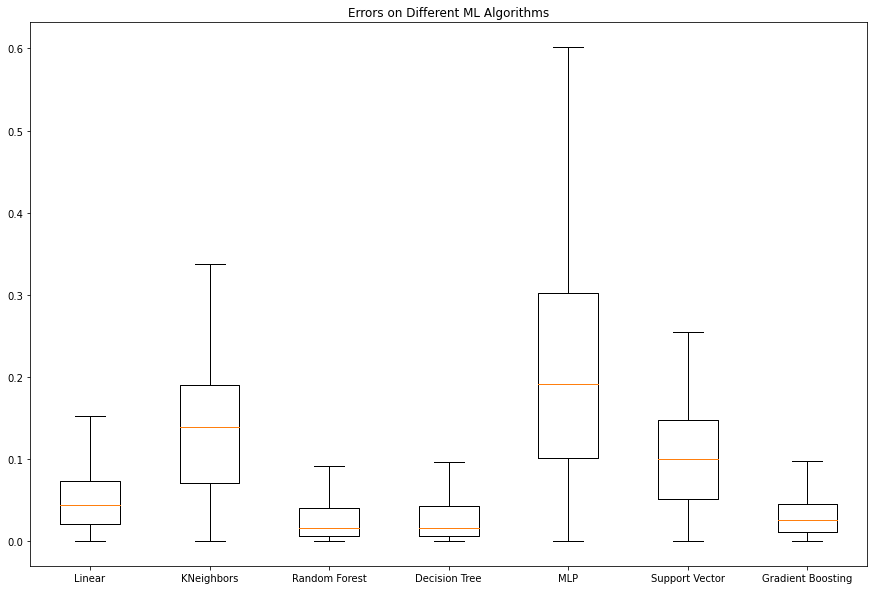

In [491]:
dataError = []

lrsoe = np.abs(y_pred_lr_soe_nd - y_test_lr_soe_nd).to_numpy().reshape(4362, )
dataError.append(lrsoe)

y_pred_knr_soe_nd = y_pred_knr_soe_nd.reshape(4362, 1)
knrsoe = np.abs(y_pred_knr_soe_nd - y_test_knr_soe_nd).to_numpy().reshape(4362, )
dataError.append(knrsoe)

y_pred_rfr_soe_nd = y_pred_rfr_soe_nd.reshape(4362, 1)
rfrsoe = np.abs(y_pred_rfr_soe_nd - y_test_rfr_soe_nd).to_numpy().reshape(4362, )
dataError.append(rfrsoe)



y_pred_dtr_soe_nd = y_pred_dtr_soe_nd.reshape(4362, 1)
dtrsoe = np.abs(y_pred_dtr_soe_nd - y_test_dtr_soe_nd).to_numpy().reshape(4362, )
dataError.append(dtrsoe)


y_pred_mlpr_soe_nd = y_pred_mlpr_soe_nd.reshape(4362, 1)
mlprsoe = np.abs(y_pred_mlpr_soe_nd - y_test_mlpr_soe_nd).to_numpy().reshape(4362, )
dataError.append(mlprsoe)


y_pred_svm_soe_nd = y_pred_svm_soe_nd.reshape(4362, 1)
svmsoe = np.abs(y_pred_svm_soe_nd - y_test_svm_soe_nd).to_numpy().reshape(4362, )
dataError.append(svmsoe)


y_pred_gbr_soe_nd = y_pred_gbr_soe_nd.reshape(4362, 1)
gbrsoe = np.abs(y_pred_gbr_soe_nd - y_test_gbr_soe_nd).to_numpy().reshape(4362, )
dataError.append(gbrsoe)



boxplot(dataError)

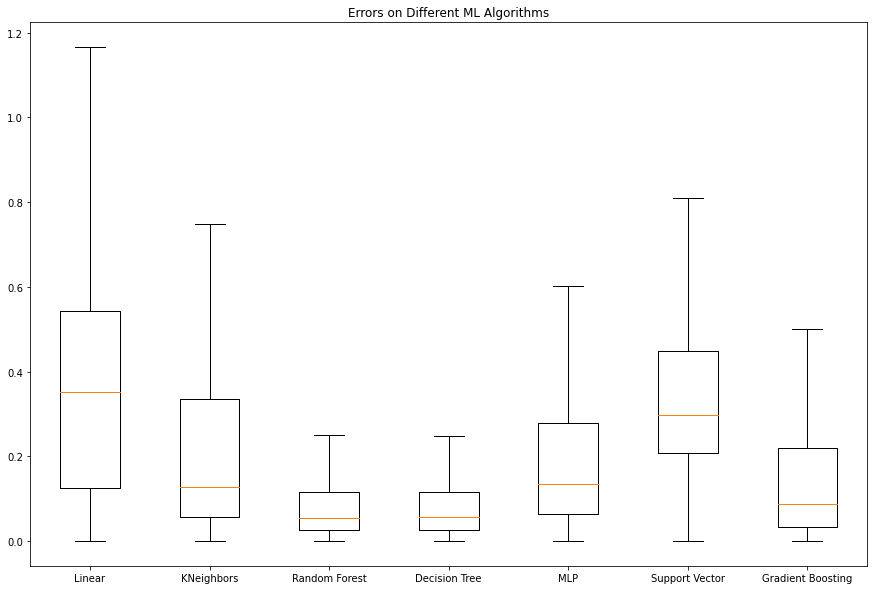

In [492]:
#SINGLE OUTPU

dataSpeedup = []

lrsox = np.abs(y_pred_lr_sox_nd - y_test_lr_sox_nd).to_numpy().reshape(4362, )
dataSpeedup.append(lrsox)

y_pred_knr_sox_nd = y_pred_knr_sox_nd.reshape(4362, 1)
knrsox = np.abs(y_pred_knr_sox_nd - y_test_knr_sox_nd).to_numpy().reshape(4362, )
dataSpeedup.append(knrsox)

y_pred_rfr_sox_nd = y_pred_rfr_sox_nd.reshape(4362, 1)
rfrsox = np.abs(y_pred_rfr_sox_nd - y_test_rfr_sox_nd).to_numpy().reshape(4362, )
dataSpeedup.append(rfrsox)



y_pred_dtr_sox_nd = y_pred_dtr_sox_nd.reshape(4362, 1)
dtrsox = np.abs(y_pred_dtr_sox_nd - y_test_dtr_sox_nd).to_numpy().reshape(4362, )
dataSpeedup.append(dtrsox)


y_pred_mlpr_sox_nd = y_pred_mlpr_sox_nd.reshape(4362, 1)
mlprsox = np.abs(y_pred_mlpr_sox_nd - y_test_mlpr_sox_nd).to_numpy().reshape(4362, )
dataSpeedup.append(mlprsox)


y_pred_svm_sox_nd = y_pred_svm_sox_nd.reshape(4362, 1)
svmsox = np.abs(y_pred_svm_sox_nd - y_test_svm_sox_nd).to_numpy().reshape(4362, )
dataSpeedup.append(svmsox)


y_pred_gbc_sox_nd = y_pred_gbc_sox_nd.reshape(4362, 1)
gbcsox = np.abs(y_pred_gbc_sox_nd - y_test_gbc_sox_nd).to_numpy().reshape(4362, )
dataSpeedup.append(gbcsox)



boxplot(dataSpeedup)